# NYC Taxi Trip (Fare, Distance and Duration) Prediction <a class="tocSkip">
## Project using real data from NYC Taxi & Limousine Commission (TLC) <a class="tocSkip">

UDD - Universidad del Desarrollo<br>
MDS - Master in Data Science<br><br>
This Notebook is to be used as part of the final evaluation on:
- Advanced Machine Learning (AML) and, 
- Project 1 (PP1)<br>

**Students**
- Briceño, Heriberto
- Rovai, Marcelo
- Sacasa, Manuel

**Professors**
- Bravo, Loreto (PP1)
- Schifanella, Rossano (AML)
    
March, 2019

![image](./images/taxi_fare.png)

---

## NYC Yellow Cab general info

Yellow Medallion Taxicabs are iconic to New York City. There are currently over 13,000 licensed taxicabs and over 50,000 taxicab drivers providing transportation for passengers in all five boroughs via street hails. Medallion taxicab drivers must follow a set of TLC requirements in order to be licensed to drive a yellow taxicab.DEtaild can be find on oficial TLC site:<br>
http://www.nyc.gov/html/tlc/html/industry/yellow_taxi.shtml

**Fare Information**
- The initial charge is USD 2.50.
- Plus 50 cents per 1/5 mile or 50 cents per 60 seconds in slow traffic or when the vehicle is stopped.
- There is a 50-cent MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
- There is a 30-cent Improvement Surcharge. 
- There is a daily 50-cent surcharge from 8pm to 6am.
- There is a USD 1 surcharge from 4pm to 8pm on weekdays, excluding holidays.
- Passengers must pay all bridge and tunnel tolls.
- There are no charges for extra passengers or bags.

**Airport Trips**

- To & From LaGuardia (LGA) Airport: This is a metered fare.
- To/From JFK : Flat fare of USD 52 plus tolls + 50-cent MTA State Surcharge, + 30-cent Improvement Surcharge + USD 4.50 rush hour surcharge (4 PM to 8 PM weekdays, excluding legal holidays).
- To Newark Airport (EWR): This is a metered fare + USD 17.50 Newark Surcharge + 30-cent Improvement Surcharge. 

**NYC 5 Boroughs city limit**
- Center coordinates:
 - 40.7127, -74.0059<br>
![image](./images/NYC-5boros-map.png)

## dataset 

http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

### Data Dictionary – Yellow Taxi Trip Records

**VendorID**
- A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.

**tpep_pickup_datetime**
- The date and time when the meter was engaged.

**tpep_dropoff_datetime**
- The date and time when the meter was disengaged.

**Passenger_count**
- The number of passengers in the vehicle. This is a driver-entered value.

**Trip_distance**
- The elapsed trip distance in miles reported by the taximeter.

**pickup_longitud and pickup_latitude**
- Location in which the taximeter was engaged

**dropoff_longitud and dropoff_latitude**
- Location in which the taximeter was disengaged

**RateCodeID**
- The final rate code in effect at the end of the trip.
 - 1 = Standard rate
 - 2 = JFK
 - 3 = Newark
 - 4 = Nassau or Westchester 
 - 5 = Negotiated fare 
 - 6 = Group ride

**store_and_fwd_flag**
- This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.
 - Y= store and forward trip
 - N= not a store and forward trip

**payment_type**
- A numeric code signifying how the passenger paid for the trip.
 - 1 = Credit card 
 - 2 = Cash
 - 3 = No charge 
 - 4 = Dispute
 - 5 = Unknown 
 - 6 = Voided trip

**fare_amount**
- The time-and-distance fare calculated by the meter.

**extra**
- Miscellaneous extras and surcharges. Currently, this only includes the USD 0.50 and USD 1 rush hour and overnight charges. 

**mta_tax**
- USD 0.50 MTA tax that is automatically triggered based on the metered rate in use.

**Improvement_surcharge**
- USD 0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

**tip_amount**
- Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

**tolls_amount**
- Total amount of all tolls paid in trip.

**total_amount**
- The total amount charged to passengers. Does not include cash tips.

### Specific subset to be downloaded
- June 2015 ==> 12.3M rows<br>

https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-06.csv

### NYC Borough Boundaries
- [GIS data](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm/data): Boundaries of Boroughs (water areas excluded)
- https://data.cityofnewyork.us/api/views/7t3b-ywvw/rows.csv?accessType=DOWNLOAD

---

## References
[1](http://cs229.stanford.edu/proj2016/report/AntoniadesFadaviFobaAmonJuniorNewYorkCityCabPricing-report.pdf) - Fare and Duration Prediction: A Study of New York City Taxi Rides, Antoniades and others - 2016<br>
[2](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.646.8961&rep=rep1&type=pdf) - Providing Real-Time Feedback for a Large Taxi Fleet, Balan and others - 2011  <br>


---

## Libraries, Initial setup and general functions

In [3]:
from math import radians, cos, sin, asin, sqrt, atan2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.mpl.rc("figure", figsize=(10, 6))
plt.style.use('fivethirtyeight')

In [5]:
def plot_bound_map(lat_min, long_min, lat_max, long_max, zoom=3):
    line = Polyline(
        locations=[[[[lat_min, long_min], [lat_min, long_max], [lat_max, long_max],
                     [lat_max, long_min], [lat_min, long_min]]]],
        color="green",
        fill_color="green")
    m = Map(center=(40.7127, -74.0059), zoom=zoom)
    m.add_layer(line)
    return m

In [6]:
def plot_map_fill_multiples_ids(title, bb, sf, 
                                               x_lim = None, 
                                               y_lim = None, 
                                               figsize = (11,9), 
                                               color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)

    for shape in sf.shapeRecords():
        for i in range(len(shape.shape.parts)):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            plt.plot(x, y, 'k')
            
    for id in bb:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        
        if (color != None):
            ax.fill(x_lon,y_lat, color)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0-0.035, y0+0.01, sf.records()[id][1], fontsize=14, color='r')
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [7]:
def polygon_create(sf, id):  
    coords = list()
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]

    for i in range(len(x_lon)):
        data = ((x_lon[i], y_lat[i]))
        coords.append(data)  
    return Polygon(coords)

## Defining a polygon for Manhattan 

In [8]:
import shapefile as shp
from shapely.geometry import Point, Polygon

In [9]:
!ls ./data/NYC_BB

geo_export_8cc1e1df-036a-4a38-ae67-63772ec4de2a.dbf
geo_export_8cc1e1df-036a-4a38-ae67-63772ec4de2a.prj
geo_export_8cc1e1df-036a-4a38-ae67-63772ec4de2a.shp
geo_export_8cc1e1df-036a-4a38-ae67-63772ec4de2a.shx
nybb.csv


In [10]:
shp_path = "./data/NYC_BB/geo_export_8cc1e1df-036a-4a38-ae67-63772ec4de2a.shp"
sf = shp.Reader(shp_path)

In [11]:
len(sf.shapes())

5

`Those are the 5 NYC boroughs`

In [12]:
print ("0: ", sf.records()[0][1])
print ("1: ", sf.records()[1][1])
print ("2: ", sf.records()[2][1])
print ("3: ", sf.records()[3][1])
print ("4: ", sf.records()[4][1])

0:  Manhattan
1:  Bronx
2:  Staten Island
3:  Brooklyn
4:  Queens


`On first row the data regarding Manhattan`

<Figure size 792x648 with 0 Axes>

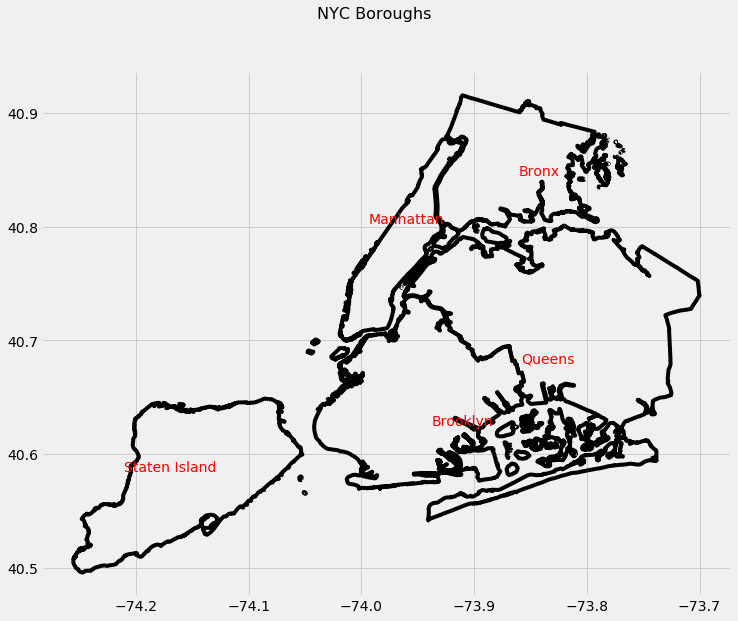

In [13]:
bb_id = [0, 1, 2, 3, 4]
plot_map_fill_multiples_ids("NYC Boroughs", bb_id, sf, color = None)

In [14]:
manh_poly = polygon_create(sf, 0)

In [15]:
# Points for testing
p_man = Point(-74, 40.72)
p_que = Point(-73.8, 40.7)

In [16]:
p_man.within(manh_poly)

True

In [17]:
p_que.within(manh_poly)

False

## EDA 

In [16]:
df = pd.read_csv("./data/yellow_tripdata_2015-06.csv", )
df.shape

(12324935, 19)

In [17]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-06-02 11:19:29,2015-06-02 11:47:52,1,1.63,-73.954430,40.764141,1,N,-73.974754,40.754093,2,17.0,0.0,0.5,0.00,0.0,0.3,17.80
1,2,2015-06-02 11:19:30,2015-06-02 11:27:56,1,0.46,-73.971443,40.758942,1,N,-73.978539,40.761909,1,6.5,0.0,0.5,1.00,0.0,0.3,8.30
2,2,2015-06-02 11:19:31,2015-06-02 11:30:30,1,0.87,-73.978111,40.738434,1,N,-73.990273,40.745438,1,8.0,0.0,0.5,2.20,0.0,0.3,11.00
3,2,2015-06-02 11:19:31,2015-06-02 11:39:02,1,2.13,-73.945892,40.773529,1,N,-73.971527,40.760330,1,13.5,0.0,0.5,2.86,0.0,0.3,17.16
4,1,2015-06-02 11:19:32,2015-06-02 11:32:49,1,1.40,-73.979088,40.776772,1,N,-73.982162,40.758999,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30


### Deleting rows with missing data

In [18]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12324935 entries, 0 to 12324934
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.7+ GB


In [20]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07
mean,1.523565e+00,1.681898e+00,1.182908e+01,-7.291385e+01,4.016687e+01,1.041832e+00,-7.294474e+01,4.018478e+01,1.379517e+00,1.320408e+01,3.234049e-01,4.976184e-01,1.736538e+00,3.161518e-01,2.997213e-01,1.637827e+01
std,4.994444e-01,1.335180e+00,7.678550e+03,8.796762e+00,4.843162e+00,5.819572e-01,8.669562e+00,4.777574e+00,4.995277e-01,1.060766e+02,4.804153e-01,4.214822e-02,2.637613e+00,1.542573e+00,1.216386e-02,1.063828e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,-7.592333e+02,-6.713696e+01,1.000000e+00,-7.541667e+02,-1.617787e+01,1.000000e+00,-3.000000e+02,-3.050000e+01,-5.000000e-01,-8.000000e+01,-1.400000e+01,-3.000000e-01,-3.000000e+02
25%,1.000000e+00,1.000000e+00,1.010000e+00,-7.399190e+01,4.073614e+01,1.000000e+00,-7.399130e+01,4.073463e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,2.000000e+00,1.000000e+00,1.750000e+00,-7.398154e+01,4.075323e+01,1.000000e+00,-7.397962e+01,4.075380e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.160000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,2.000000e+00,3.230000e+00,-7.396646e+01,4.076793e+01,1.000000e+00,-7.396248e+01,4.076879e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.350000e+00,0.000000e+00,3.000000e-01,1.830000e+01
max,2.000000e+00,9.000000e+00,1.008332e+07,1.490285e+02,6.970258e+01,9.900000e+01,1.255356e+02,4.834500e+02,5.000000e+00,3.354137e+05,6.524200e+02,6.035000e+01,9.809100e+02,9.009700e+02,7.000000e-01,3.354145e+05


In [21]:
len(df[df.store_and_fwd_flag == 'Y'])

94988

`Great majority of trips was recorded online.`

### Changing datatime format

`pickup_datatime is not a datatime type and must be converted`

In [22]:
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [23]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12324935 entries, 0 to 12324934
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: datetime64[ns](2), float64(12), int64(4), object(1)
memory usage: 1.7+ GB


In [25]:
df['tpep_pickup_datetime'].min()

Timestamp('2015-06-01 00:00:00')

In [26]:
df['tpep_pickup_datetime'].max()

Timestamp('2015-06-30 23:59:59')

In [27]:
df['tpep_dropoff_datetime'].min()

Timestamp('2015-06-01 00:00:00')

In [28]:
df['tpep_dropoff_datetime'].max()

Timestamp('2016-11-03 15:35:51')

In [29]:
len(df[df.tpep_dropoff_datetime > '2015-06-30 23:59:59'])

3843

In [30]:
len(df[df.tpep_dropoff_datetime < '2015-06-01 00:00:00'])

0

In [31]:
len(df[df.tpep_pickup_datetime > '2015-06-30 23:59:59'])

0

In [32]:
len(df[df.tpep_pickup_datetime < '2015-06-01 00:00:00'])

0

In [33]:
ds_1 = len(df)
df = df[(df.tpep_dropoff_datetime >= '2015-06-01 00:00:00') &
        (df.tpep_dropoff_datetime <= '2015-06-30 23:59:59')]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  3843


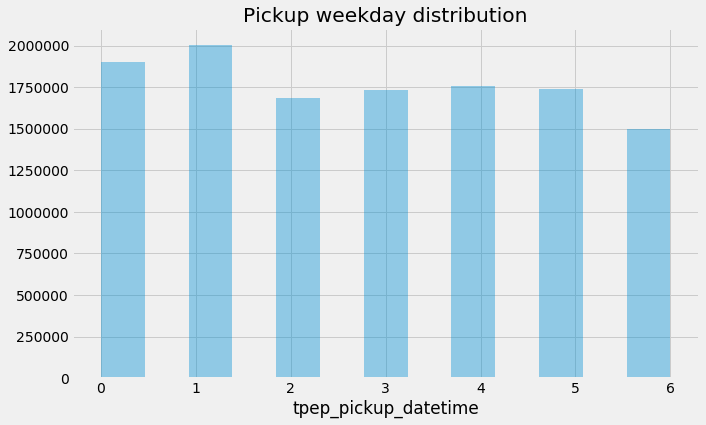

In [34]:
dw = df['tpep_pickup_datetime'].dt.dayofweek
sns.distplot(dw, bins=13, kde=False).set_title("Pickup weekday distribution");

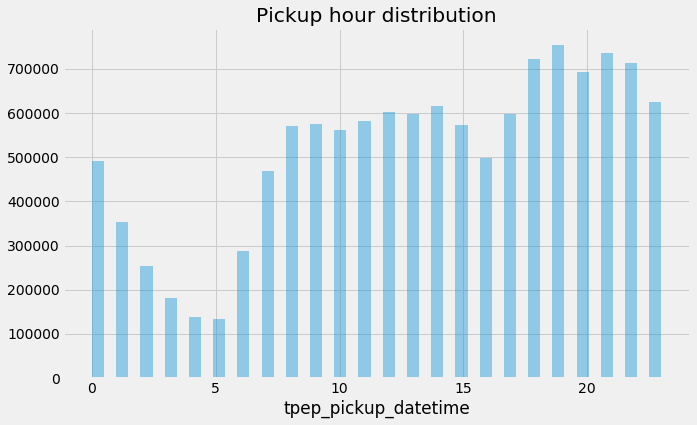

In [35]:
dh = df['tpep_pickup_datetime'].dt.hour
sns.distplot(dh, bins=47, kde=False).set_title("Pickup hour distribution");

`Trips occurs around the clock every weekly day, from monday to sunday, being monday and tuesday the busies days. Most trips occur after 7am, being less busy after midnight.` 

### Filtering passengers

In [36]:
df.passenger_count.value_counts()

1    8692213
2    1747643
5     675637
3     523449
6     432107
4     248438
0       1554
7         22
9         20
8          9
Name: passenger_count, dtype: int64

In [37]:
dp_0 = df[(df.passenger_count == 0)].trip_distance
dp_0.describe()

count    1554.000000
mean        2.363713
std         3.734680
min         0.000000
25%         0.500000
50%         1.300000
75%         2.500000
max        37.610000
Name: trip_distance, dtype: float64

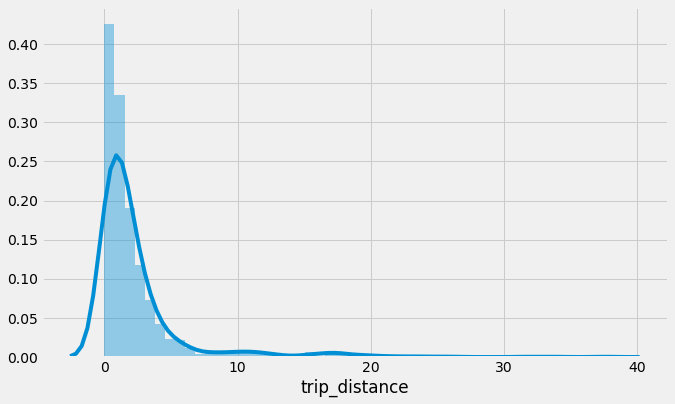

In [38]:
sns.distplot(dp_0)

`Once the trip distance for the Zero passengers is not null, this could be a kind of "pick-up/delivery goods". We will keep it.` 

`Make no sense have more then 6 passengers per trip`. 

In [39]:
ds_1 = len(df)
df = df[df.passenger_count<=6]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  51


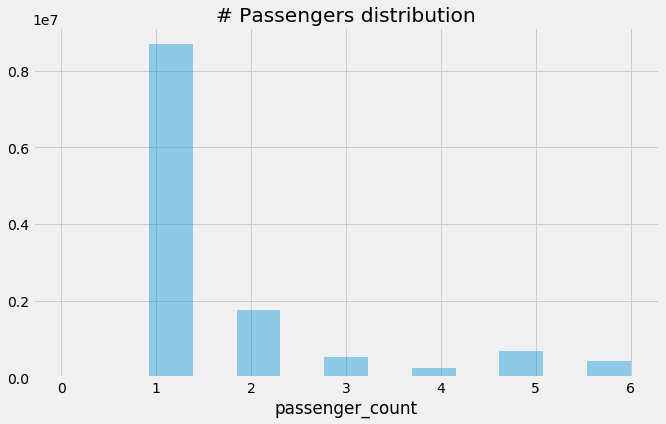

In [40]:
sns.distplot(df.passenger_count, bins=13, kde=False).set_title("# Passengers distribution");

### Filtering Fare amount

In [41]:
len(df.fare_amount.value_counts())

1940

In [42]:
a=list(df.fare_amount.unique())
a.sort()

In [43]:
a[:20]

[-300.0,
 -225.0,
 -211.5,
 -200.0,
 -187.0,
 -175.0,
 -171.0,
 -170.0,
 -160.0,
 -150.0,
 -145.0,
 -142.5,
 -135.0,
 -133.0,
 -132.0,
 -122.0,
 -120.0,
 -110.0,
 -109.0,
 -100.0]

`Looking on fair column we see that there are negative values. For starting we must eliminating any values below minimum fare of ($2.5). ===>>> Further verification in time to veryfy when minimun fare changed from $2 to $2.50`

In [44]:
ds_1 = len(df)
df = df[df.fare_amount>=2.5]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  9373


In [45]:
df.payment_type.value_counts()

1    7716156
2    4543758
3      39186
4      12566
5          2
Name: payment_type, dtype: int64

`Some payments are void, no charge, in dispute, etc. Let's keep only Credit Card and cash.`

In [46]:
ds_1 = len(df)
df = df[df.payment_type <= 2]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  51754


In [47]:
df.RateCodeID.value_counts()

1     11934183
2       266878
5        33910
3        20022
4         4602
99         239
6           80
Name: RateCodeID, dtype: int64

`There are several trips where the rate is negotiable (type = 5), a few group (6) and some noise (99). Lets keep only type 1 to 4.`

In [48]:
ds_1 = len(df)
df = df[df.RateCodeID <= 4]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  34229


### Filtering rows with latitude and longitude outside of bounders

In [18]:
from ipyleaflet import Map, Marker, Polyline

`The bounderies (lat/long) are bad. lets take NYC center coordinates (40.7127, -74.0059) and consider as bounders 1 degree (aprox 69 Miles) in each direction.`

In [19]:
lat_min = 39.7
lat_max = 41.7
long_min = -75.0
long_max = -73.0

In [20]:
plot_bound_map(lat_min, long_min, lat_max, long_max, zoom=7)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

#### Filtering rows with pickup_longitude outside of bounders

In [52]:
ds_1 = len(df)
df = df[(df.pickup_longitude>=long_min) &
                    (df.pickup_longitude<=long_max)]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  167895


#### Filtering rows with pickup_latitude outside of bounders

In [53]:
ds_1 = len(df)
df = df[(df.pickup_latitude >= lat_min) &
                    (df.pickup_latitude <= lat_max)]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  24


#### Filtering rows with dropoff_longitude outside of bounders

In [54]:
ds_1 = len(df)
df = df[(df.dropoff_longitude >= long_min) &
                    (df.dropoff_longitude <= long_max)]
ds_2 = len(df)

print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  19900


#### Filtering rows with dropoff_latitude outside of bounders

In [55]:
ds_1 = len(df)
df = df[(df.dropoff_latitude >= lat_min) &
                    (df.dropoff_latitude <= lat_max)]
ds_2 = len(df)

print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  34


#### Checking Bounders

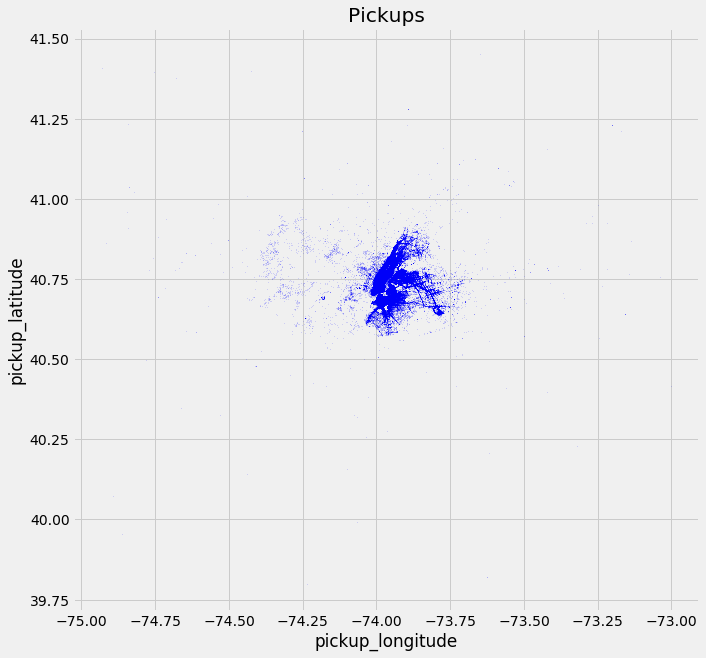

In [56]:
df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',color='blue', figsize=(10,10), s=.02, alpha=.6);
plt.title("Pickups");

`Let's zooming the city bounderies with majority of trips`

In [21]:
city_long_border = (-74.5, -73.4)
city_lat_border = (40.50, 41.15)

In [22]:
plot_bound_map(40.55, -73.7, 40.9, -74.2, zoom=10)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

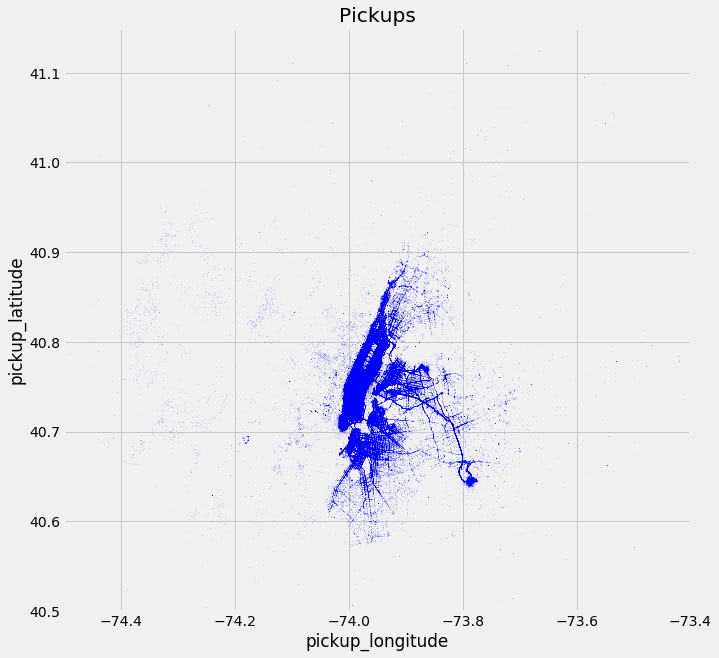

In [64]:
df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',color='blue', figsize=(10,10), s=.02, alpha=.6);
plt.title("Pickups");
plt.ylim(city_lat_border);
plt.xlim(city_long_border);

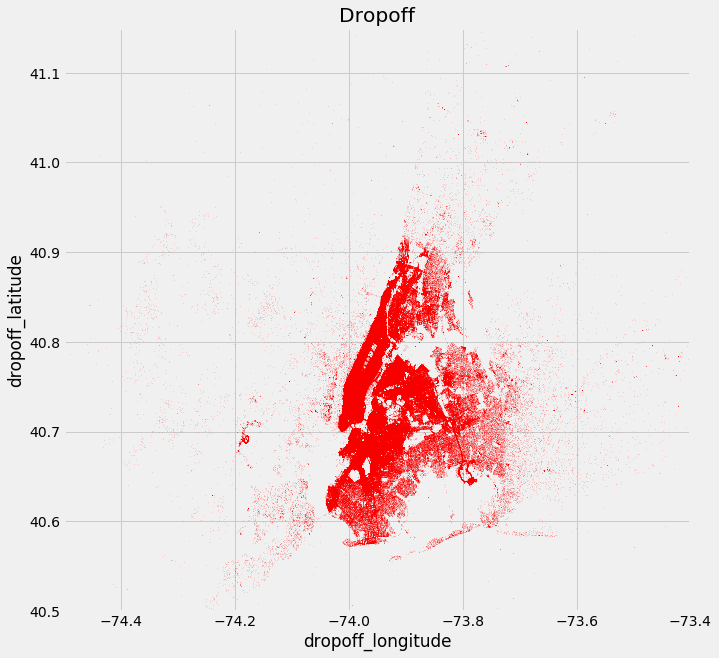

In [65]:
df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',color='red', figsize=(10,10), s=.02, alpha=.6);
plt.title("Dropoff");
plt.ylim(city_lat_border);
plt.xlim(city_long_border);

`The pickup are more concentrated being the dropoff more "spread". Also, there is a clear concentration on Manhattan and airports. For example, (-73.80, 40.64) is JFK, (-74.17, 40.69) is Newark and (-73.86, 40.77) is La Guardia`

---

### Transforming dataset

In [66]:
df.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-06-02 11:19:29,2015-06-02 11:47:52,1,1.63,-73.954430,40.764141,1,N,-73.974754,40.754093,2,17.0,0.0,0.5,0.0,0.0,0.3,17.8
1,2,2015-06-02 11:19:30,2015-06-02 11:27:56,1,0.46,-73.971443,40.758942,1,N,-73.978539,40.761909,1,6.5,0.0,0.5,1.0,0.0,0.3,8.3


In [67]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07,1.203783e+07
mean,1.529104e+00,1.687653e+00,1.141844e+01,-7.397360e+01,4.075076e+01,1.025976e+00,-7.397351e+01,4.075151e+01,1.370261e+00,1.302176e+01,3.246099e-01,4.991794e-01,1.727800e+00,3.063493e-01,2.999689e-01,1.618044e+01
std,4.991522e-01,1.341344e+00,7.502463e+03,3.832813e-02,2.790188e-02,1.755466e-01,3.561796e-02,3.174342e-02,4.828745e-01,1.033503e+01,4.824510e-01,2.694902e-02,2.499394e+00,1.411764e+00,3.057840e-03,1.290478e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-7.493171e+01,3.979726e+01,1.000000e+00,-7.496976e+01,3.973938e+01,1.000000e+00,2.500000e+00,-5.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01
25%,1.000000e+00,1.000000e+00,1.030000e+00,-7.399205e+01,4.073735e+01,1.000000e+00,-7.399140e+01,4.073605e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,2.000000e+00,1.000000e+00,1.760000e+00,-7.398182e+01,4.075392e+01,1.000000e+00,-7.397996e+01,4.075435e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.200000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,2.000000e+00,3.230000e+00,-7.396751e+01,4.076824e+01,1.000000e+00,-7.396361e+01,4.076912e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.830000e+01
max,2.000000e+00,6.000000e+00,1.008332e+07,-7.300165e+01,4.145076e+01,4.000000e+00,-7.300165e+01,4.166106e+01,2.000000e+00,6.030000e+02,6.524200e+02,6.035000e+01,8.500000e+02,5.956300e+02,7.000000e-01,6.364330e+03


`Seems that the dataset is almost done to be used on our ML project. Lets dig on Fare analysis, that is our goal here.` 

## Fare analysis 

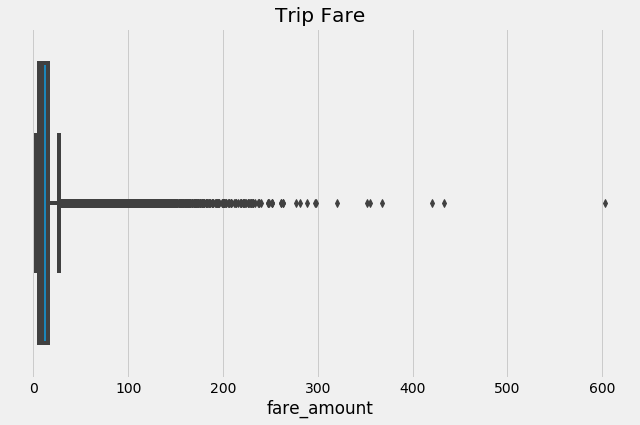

In [68]:
sns.boxplot(df['fare_amount']).set_title("Trip Fare");

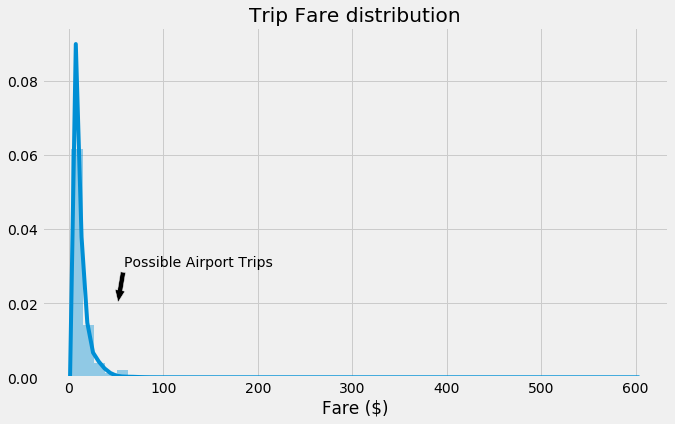

In [69]:
sns.distplot(df['fare_amount']);
plt.annotate(
    'Possible Airport Trips',
    xy=(52, 0.02),
    xytext=(58, 0.03),
    arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=5));
plt.xlabel("Fare ($)")
plt.title("Trip Fare distribution");

`There is a secundary cluster of trips, with average prices around $50 (Should be JFK Airport fixed fare). Also, is clear that fares bigger than $100 are outliers` 

In [70]:
df = df[df['fare_amount'] <= 100]

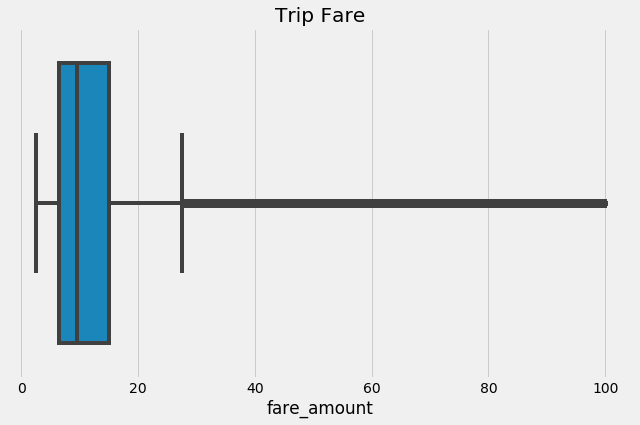

In [71]:
sns.boxplot(df['fare_amount']).set_title("Trip Fare");

`Let's go deeper on airport:` 

In [31]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="udd_pp1")

In [73]:
location = geolocator.geocode("JFK")
location.address

'John F. Kennedy International Airport, Terminal 5 Arrivals, Bayswater, Queens County, NYC, New York, 11430, USA'

In [74]:
JFK_bb = location.raw['boundingbox']
JFK_bb

['40.6210509', '40.6647615', '-73.8232337', '-73.7483913']

Text(0.5, 1.0, 'JFK Airport Trips distribution per Fare')

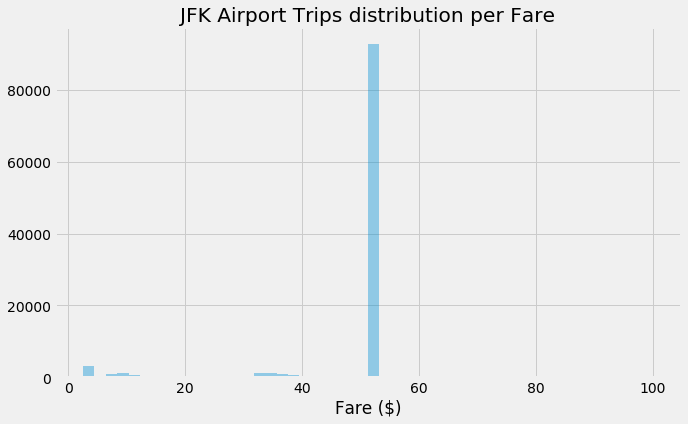

In [75]:
d_jfk = df[(df['dropoff_latitude'] >= float(JFK_bb[0])) &
           (df['dropoff_latitude'] <= float(JFK_bb[1])) &
           (df['dropoff_longitude'] >= float(JFK_bb[2])) &
           (df['dropoff_longitude'] <= float(JFK_bb[3]))]

sns.distplot(d_jfk['fare_amount'], kde=False)
plt.xlabel("Fare ($)")
plt.title("JFK Airport Trips distribution per Fare")

`We can confirm that there are hundreds of trips to JFK, where the fare is fixed values` 

`let's use the RateCodeID = 2 (JFK)`

Text(0.5, 1.0, 'JFK Airport Trips distribution per Fare')

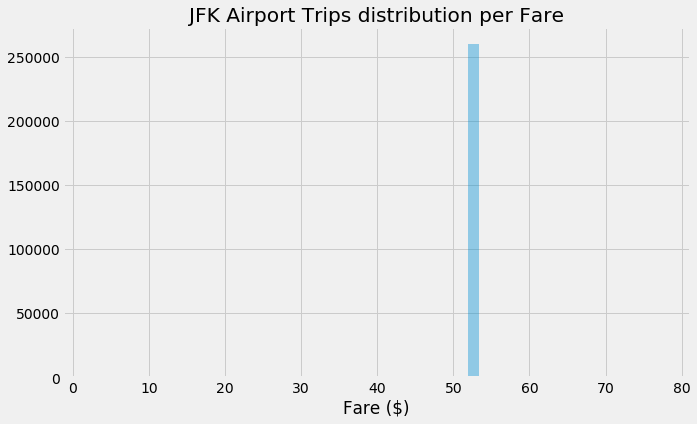

In [76]:
df_JFK = df[df.RateCodeID == 2]
sns.distplot(df_JFK['fare_amount'], kde=False)
plt.xlabel("Fare ($)")
plt.title("JFK Airport Trips distribution per Fare")

`The interesting thing here is that there are 3 times more trips registered as JFK, but that is outside of the JFK defined box.`

In [77]:
location = geolocator.geocode("EWR")
location.address

'Newark Liberty International Airport, Express Road, Newark, Essex County, New Jersey, 07114, USA'

In [78]:
EWR_bb = location.raw['boundingbox']
EWR_bb

['40.6701316', '40.7081477', '-74.1920592', '-74.1532317']

Text(0.5, 1.0, 'EWR Airport Trips distribution per Fare')

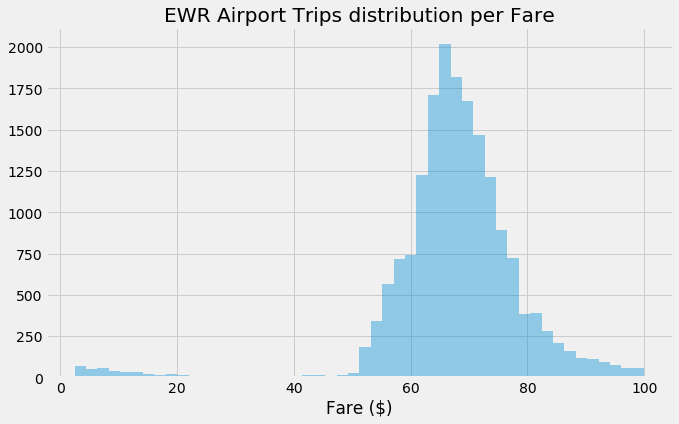

In [79]:
d_ewr = df[(df['dropoff_latitude'] >= float(EWR_bb[0])) &
           (df['dropoff_latitude'] <= float(EWR_bb[1])) &
           (df['dropoff_longitude'] >= float(EWR_bb[2])) &
           (df['dropoff_longitude'] <= float(EWR_bb[3]))]

sns.distplot(d_ewr['fare_amount'], kde=False)
plt.xlabel("Fare ($)")
plt.title("EWR Airport Trips distribution per Fare")

Text(0.5, 1.0, 'EWR Airport Trips distribution per Fare')

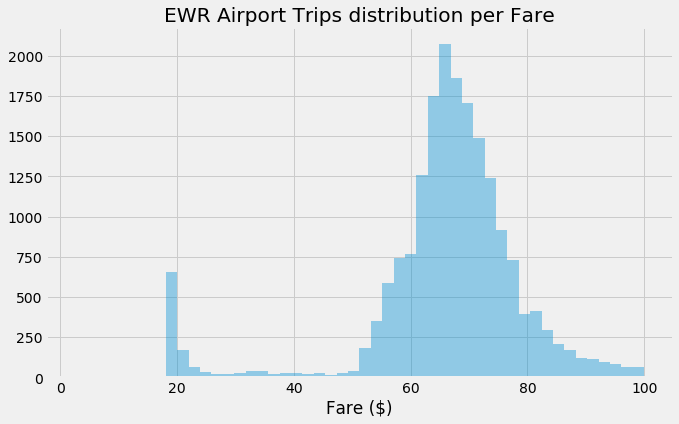

In [80]:
df_EWR = df[df.RateCodeID == 3]
sns.distplot(df_EWR['fare_amount'], kde=False)
plt.xlabel("Fare ($)")
plt.title("EWR Airport Trips distribution per Fare")

`Here the Fare Code ID and the airport geo fence are similar.`

Text(0.5, 1.0, 'NASSAU or WESTCHESTER Trips distribution per Fare')

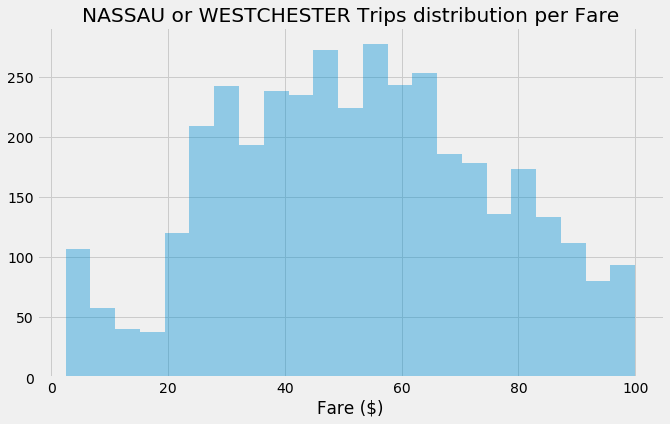

In [81]:
df_NAS = df[df.RateCodeID == 4]
sns.distplot(df_NAS['fare_amount'], kde=False)
plt.xlabel("Fare ($)")
plt.title("NASSAU or WESTCHESTER Trips distribution per Fare")

In [82]:
location = geolocator.geocode("LGA")
location.address

'LaGuardia Airport, C5, North Beach, Queens County, NYC, New York, 11369, USA'

In [83]:
LGA_bb = location.raw['boundingbox']
LGA_bb

['40.7649593', '40.7864582', '-73.8892502', '-73.851225']

Text(0.5, 1.0, 'LGA Airport Trips distribution per Fare')

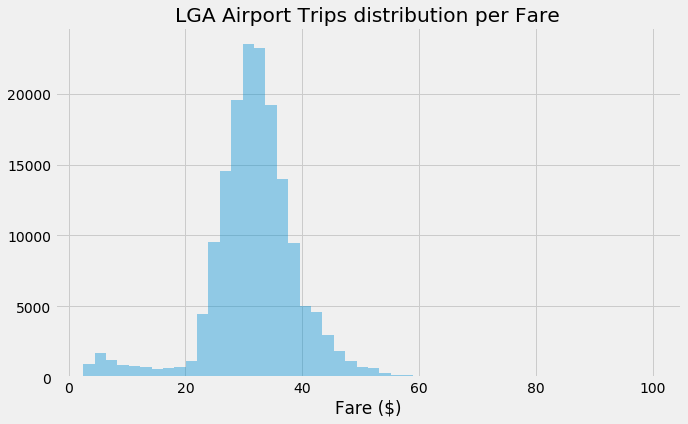

In [84]:
d_lga = df[(df['dropoff_latitude'] >= float(LGA_bb[0])) &
           (df['dropoff_latitude'] <= float(LGA_bb[1])) &
           (df['dropoff_longitude'] >= float(LGA_bb[2])) &
           (df['dropoff_longitude'] <= float(LGA_bb[3]))]

sns.distplot(d_lga['fare_amount'], kde=False)
plt.xlabel("Fare ($)")
plt.title("LGA Airport Trips distribution per Fare")

`NASSAU or WESTCHESTER, has a fixed fee according TLC, but we do see an importan pattern as we saw with JFK. La Guardia Airport has a clear mid point of around $30-$35, that seems fixed, but should be due normal fare. `

### Fare Variation per number of passenger

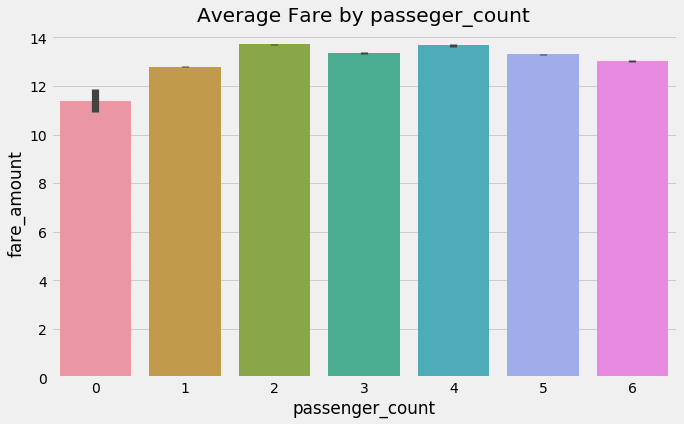

In [85]:
sns.barplot(x='passenger_count', y='fare_amount', data=df)
plt.title("Average Fare by passeger_count");

`Fare does not seems to change much with passenger_count, what confirms what is stated on TLC site (no extra fee for extra passengers. `  

### Fare Variation in time

In [86]:
df = df.sort_values(by='tpep_pickup_datetime').reset_index(drop=True)

In [87]:
df['day'] = df['tpep_pickup_datetime'].dt.day
df['weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['hour'] = df['tpep_pickup_datetime'].dt.hour

In [88]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,day,weekday,hour
0,1,2015-06-01 00:00:00,2015-06-01 00:06:12,1,1.00,-73.988739,40.756832,1,N,-73.974701,...,6.0,0.5,0.5,0.00,0.00,0.3,7.30,1,0,0
1,2,2015-06-01 00:00:00,2015-06-01 00:00:00,1,0.90,-73.984428,40.737209,1,N,-73.979935,...,11.5,1.0,0.5,2.00,0.00,0.3,15.30,1,0,0
2,2,2015-06-01 00:00:00,2015-06-01 00:00:00,2,1.40,-73.987160,40.738972,1,N,-73.976288,...,11.5,0.0,0.5,0.00,0.00,0.3,12.30,1,0,0
3,2,2015-06-01 00:00:01,2015-06-01 00:11:29,1,7.41,-73.874634,40.774082,1,N,-73.944809,...,21.0,0.5,0.5,5.57,5.54,0.3,33.41,1,0,0
4,2,2015-06-01 00:00:01,2015-06-01 00:24:48,1,8.15,-74.006844,40.730572,1,N,-73.946342,...,26.5,0.5,0.5,2.50,0.00,0.3,30.30,1,0,0


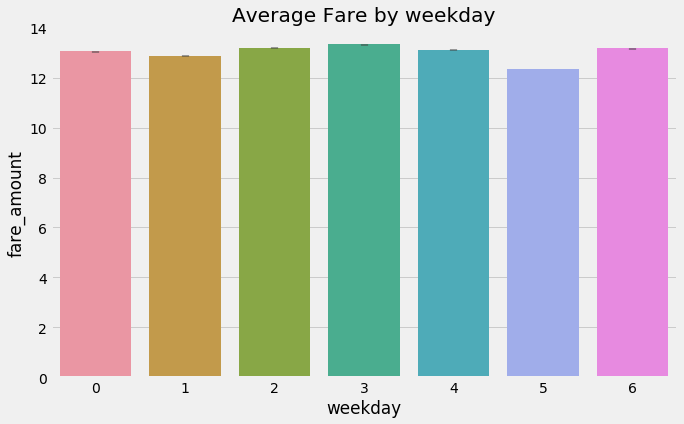

In [89]:
sns.barplot(x='weekday', y='fare_amount', data=df)
plt.title("Average Fare by weekday");

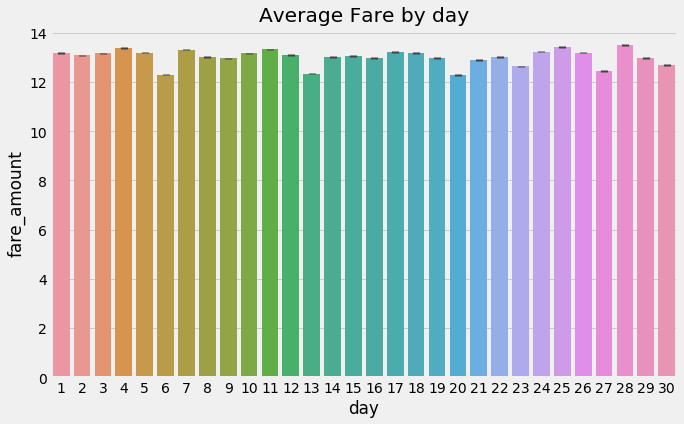

In [90]:
sns.barplot(x='day', y='fare_amount', data=df)
plt.title("Average Fare by day");

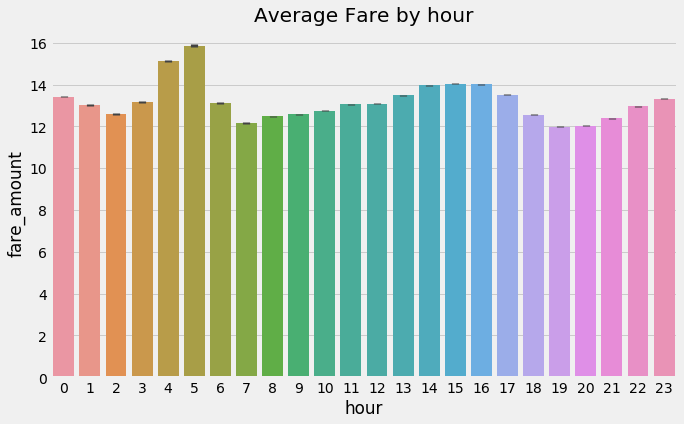

In [91]:
sns.barplot(x='hour', y='fare_amount', data=df)
plt.title("Average Fare by hour");

`Seems that fare has some retionship with hour of the day. Also depending on traffic, the lenght of trip in time should go up and so the fare. There are a significant increase of fare amount during early hours and mid afternoon.`

Text(0.5, 1.0, 'JFK Airport Trips distribution per Hour')

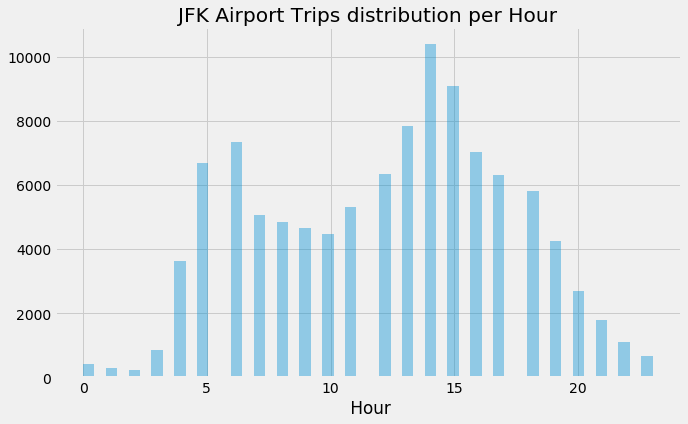

In [92]:
d_jfk = df[(df['dropoff_latitude'] >= float(JFK_bb[0])) &
           (df['dropoff_latitude'] <= float(JFK_bb[1])) &
           (df['dropoff_longitude'] >= float(JFK_bb[2])) &
           (df['dropoff_longitude'] <= float(JFK_bb[3]))]

sns.distplot(d_jfk['hour'], kde=False)
plt.xlabel(" Hour")
plt.title("JFK Airport Trips distribution per Hour")

Text(0.5, 1.0, 'JFK Airport Trips distribution per Fare')

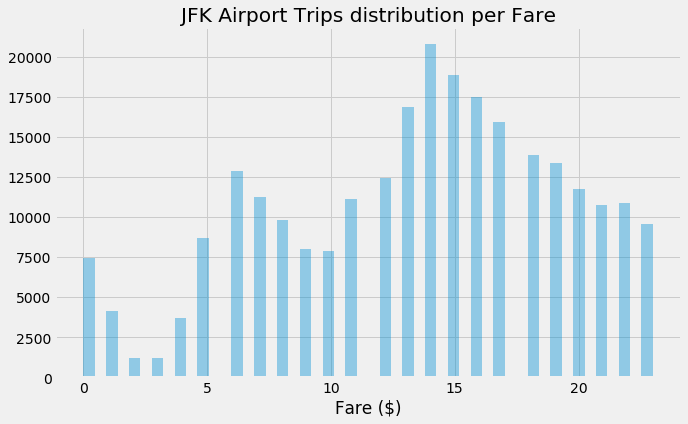

In [93]:
df_JFK = df[df.RateCodeID == 2]
sns.distplot(df_JFK['hour'], kde=False)
plt.xlabel("Fare ($)")
plt.title("JFK Airport Trips distribution per Fare")

Text(0.5, 1.0, 'EWR Airport Trips distribution per Hour')

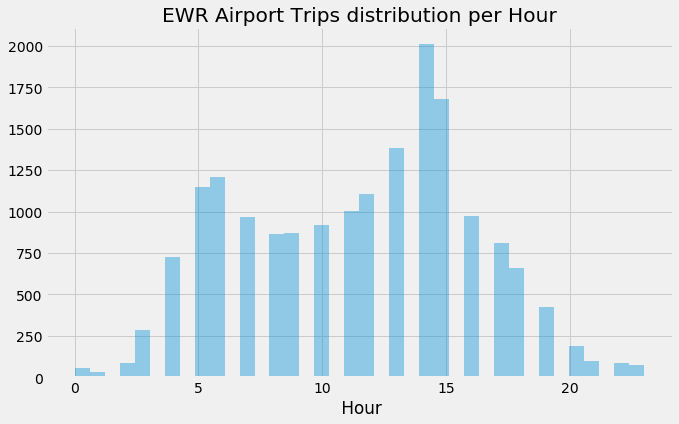

In [94]:
d_ewr = df[(df['dropoff_latitude'] >= float(EWR_bb[0])) &
           (df['dropoff_latitude'] <= float(EWR_bb[1])) &
           (df['dropoff_longitude'] >= float(EWR_bb[2])) &
           (df['dropoff_longitude'] <= float(EWR_bb[3]))]

sns.distplot(d_ewr['hour'], kde=False)
plt.xlabel(" Hour")
plt.title("EWR Airport Trips distribution per Hour")

Text(0.5, 1.0, 'EWR Airport Trips distribution per Fare')

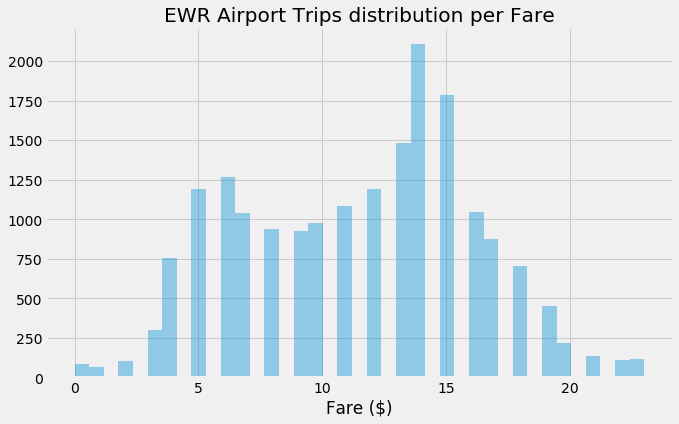

In [95]:
df_EWR = df[df.RateCodeID == 3]
sns.distplot(df_EWR['hour'], kde=False)
plt.xlabel("Fare ($)")
plt.title("EWR Airport Trips distribution per Fare")

Text(0.5, 1.0, 'LGA Airport Trips distribution per Hour')

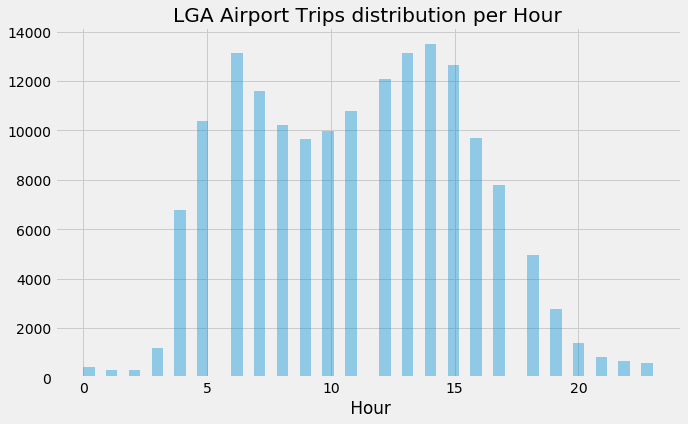

In [96]:
d_lga = df[(df['dropoff_latitude'] >= float(LGA_bb[0])) &
           (df['dropoff_latitude'] <= float(LGA_bb[1])) &
           (df['dropoff_longitude'] >= float(LGA_bb[2])) &
           (df['dropoff_longitude'] <= float(LGA_bb[3]))]

sns.distplot(d_lga['hour'], kde=False)
plt.xlabel(" Hour")
plt.title("LGA Airport Trips distribution per Hour")

` The significant increase of fare amount during early hours and mid afternoon is due airport trips as saw on previous graphs` .

## Analyzing "distance feature" 

In [97]:
df['trip_distance'].describe()

count    1.203626e+07
mean     1.141538e+01
std      7.502955e+03
min      0.000000e+00
25%      1.030000e+00
50%      1.760000e+00
75%      3.230000e+00
max      1.008332e+07
Name: trip_distance, dtype: float64

In [98]:
len(df[df['trip_distance'] > 100])

116

`There are few trips with distance greater than 100 miles, what is already rare. Let's clean it.` 

In [99]:
ds_1 = len(df)
df = df[df.trip_distance < 100]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  117


In [100]:
df['trip_distance'].describe()

count    1.203614e+07
mean     3.005856e+00
std      3.600211e+00
min      0.000000e+00
25%      1.030000e+00
50%      1.760000e+00
75%      3.230000e+00
max      9.780000e+01
Name: trip_distance, dtype: float64

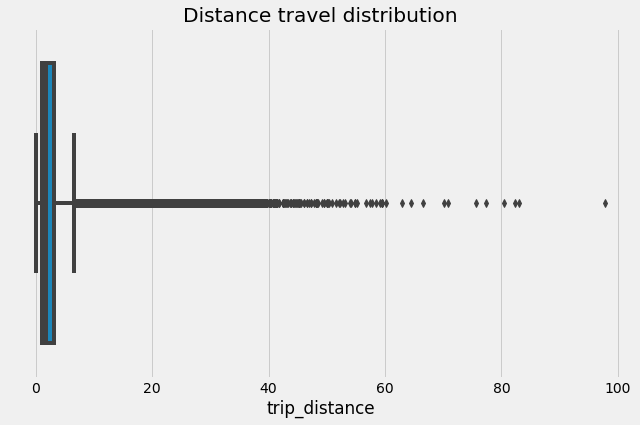

In [101]:
sns.boxplot(df['trip_distance']).set_title("Distance travel distribution");

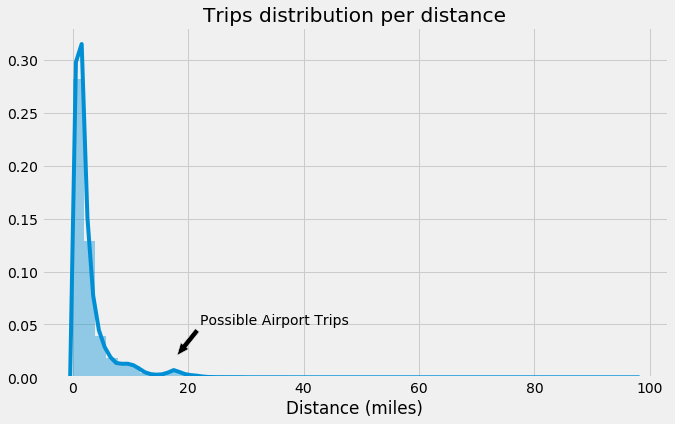

In [102]:
sns.distplot(df['trip_distance']);
plt.annotate(
    'Possible Airport Trips',
    xy=(18, 0.02),
    xytext=(22, 0.05),
    arrowprops=dict(facecolor='black', shrink=0.03, headwidth=10, width=5));
plt.xlabel("Distance (miles)")
plt.title("Trips distribution per distance");

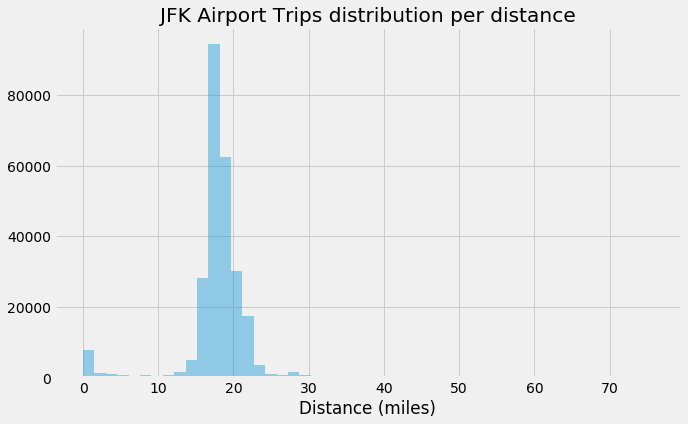

In [103]:
df_JFK = df[df.RateCodeID == 2]
sns.distplot(df_JFK['trip_distance'], kde=False)

plt.xlabel("Distance (miles)")
plt.title("JFK Airport Trips distribution per distance");

`Confirmed JFK airport at 18 miles`

`Let's also filter distances more than 40 miles`

In [104]:
df = df[df['trip_distance'] <= 40]

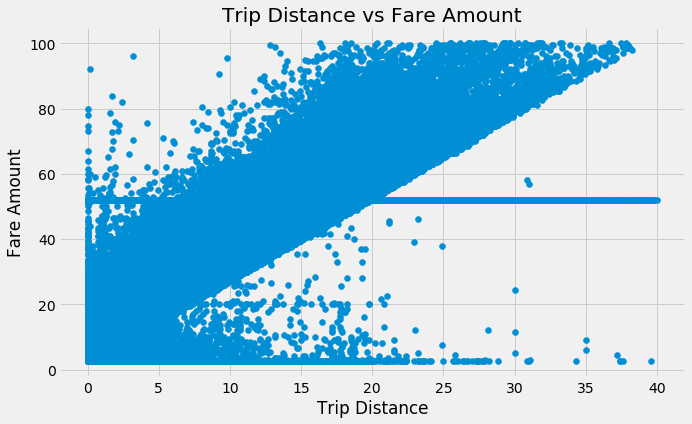

In [105]:
plt.scatter(
    x=df['trip_distance'], y=df['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount");

`There are a lot of high cost trips with very small distances, let' see it in more detail, trips with less than 7 miles (mean +std dev)`.

In [106]:
dt = df[df['trip_distance'] < 7]
len(dt.trip_distance)

10864061

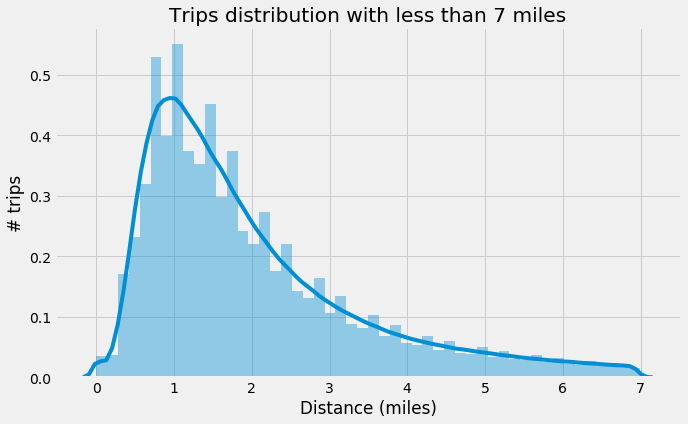

In [107]:
sns.distplot(dt['trip_distance'])
plt.xlabel("Distance (miles)")
plt.ylabel("# trips")
plt.title("Trips distribution with less than 7 miles");

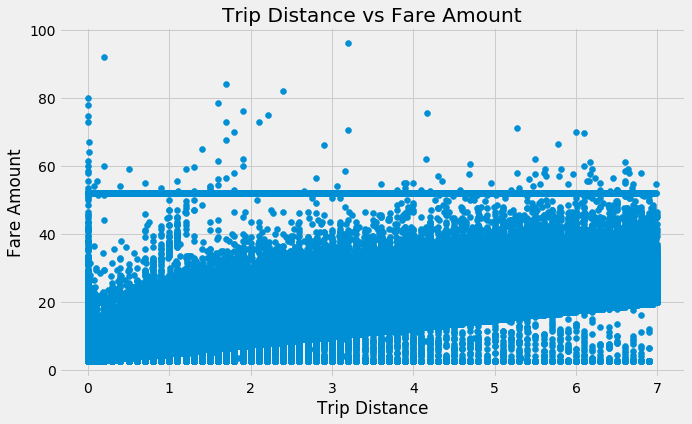

In [108]:
plt.scatter(
    x=dt['trip_distance'], y=dt['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount");

`It is clear that there a linear relation between trip distance and Fare Amount, except for Airportsm that has a fixed value. Besides, there is a non linear component, that should be "time". Lets explore it.`

## Analyzing Trip Duration

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12036034 entries, 0 to 12036254
Data columns (total 22 columns):
VendorID                 int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
day                      int64
weekday                  int64
hour                     int64
dtypes: datetime64[ns](2), float64(12), int64(7), object(1)
memory usage: 2.1+ GB


In [110]:
trip_duration = df.tpep_dropoff_datetime[0] - df.tpep_pickup_datetime[0] 
pd.Timedelta(trip_duration).seconds/60.0

6.2

In [111]:
def calc_duration(row):
    trip_duration = row['tpep_dropoff_datetime'] - row['tpep_pickup_datetime']  
    return pd.Timedelta(trip_duration).seconds/60.0

In [112]:
df['trip_duration'] = df.apply(calc_duration, axis=1)
df.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,day,weekday,hour,trip_duration
0,1,2015-06-01,2015-06-01 00:06:12,1,1.0,-73.988739,40.756832,1,N,-73.974701,...,0.5,0.5,0.0,0.0,0.3,7.3,1,0,0,6.2
1,2,2015-06-01,2015-06-01 00:00:00,1,0.9,-73.984428,40.737209,1,N,-73.979935,...,1.0,0.5,2.0,0.0,0.3,15.3,1,0,0,0.0


In [113]:
df.trip_duration.describe()

count    1.203603e+07
mean     1.546368e+01
std      3.761268e+01
min      0.000000e+00
25%      6.850000e+00
50%      1.143333e+01
75%      1.855000e+01
max      1.439983e+03
Name: trip_duration, dtype: float64

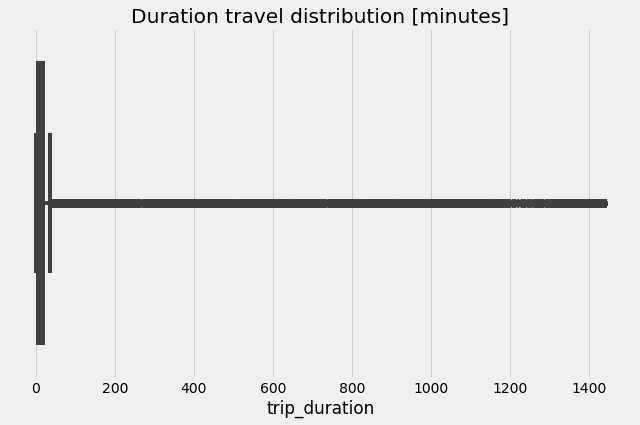

In [114]:
sns.boxplot(df['trip_duration']).set_title("Duration travel distribution [minutes]");

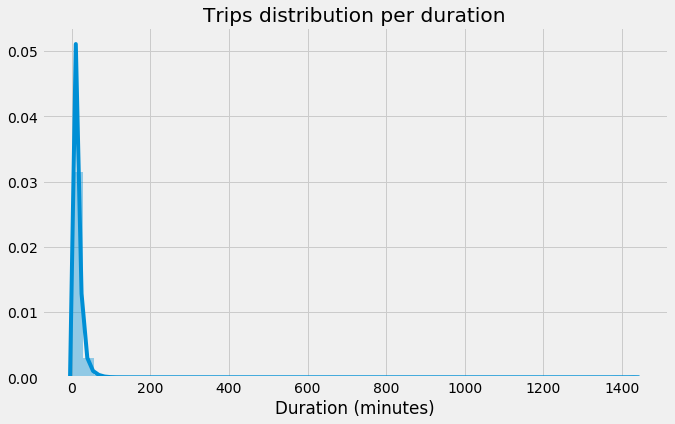

In [115]:
sns.distplot(df['trip_duration']);
plt.xlabel("Duration (minutes)")
plt.title("Trips distribution per duration");

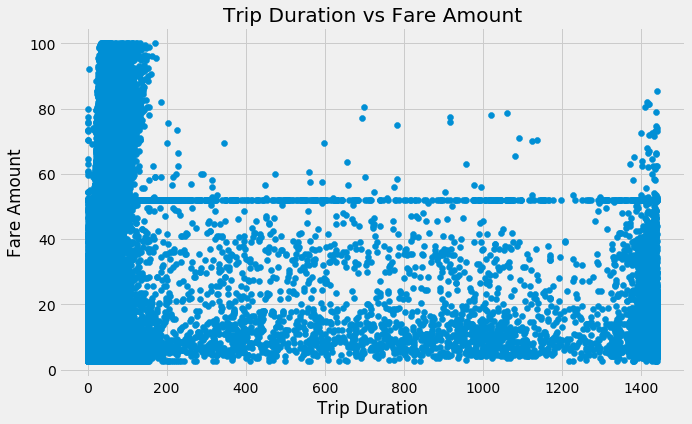

In [116]:
plt.scatter(
    x=df['trip_duration'], y=df['fare_amount'])
plt.xlabel("Trip Duration")
plt.ylabel("Fare Amount")
plt.title("Trip Duration vs Fare Amount");

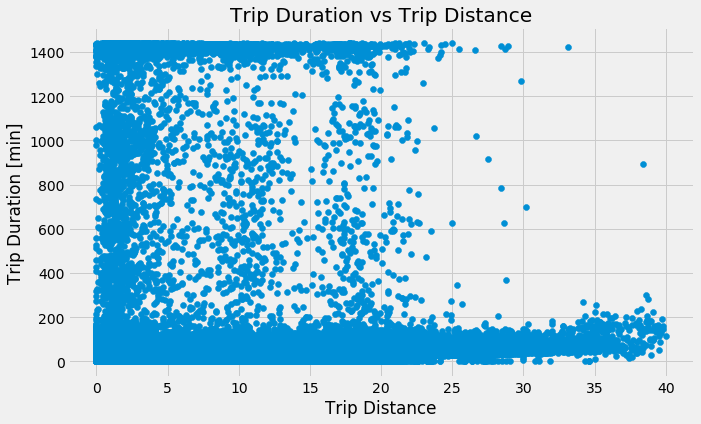

In [117]:
plt.scatter(
    x=df['trip_distance'], y=df['trip_duration'])
plt.xlabel("Trip Distance")
plt.ylabel("Trip Duration [min]")
plt.title("Trip Duration vs Trip Distance");

In [118]:
len(df[df['trip_duration'] > 180])

9462

`Less than 10.000 trips has more than 3 hours. Let's filter them`

In [119]:
ds_1 = len(df)
df = df[df.trip_duration < 180]
ds_2 = len(df)
print("# rows deleted: ", (ds_1-ds_2))

# rows deleted:  9462


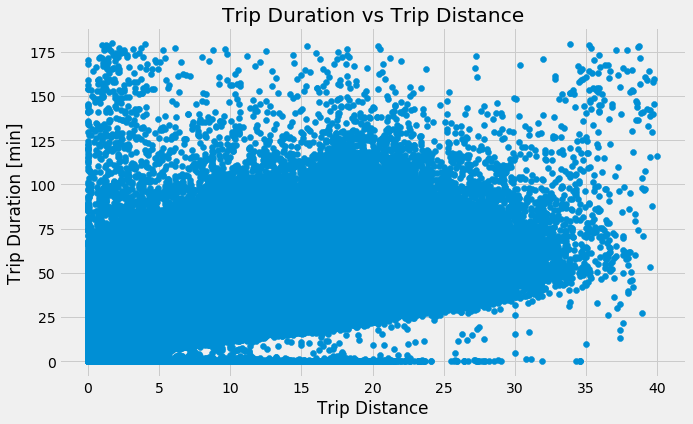

In [120]:
plt.scatter(
    x=df['trip_distance'], y=df['trip_duration'])
plt.xlabel("Trip Distance")
plt.ylabel("Trip Duration [min]")
plt.title("Trip Duration vs Trip Distance");

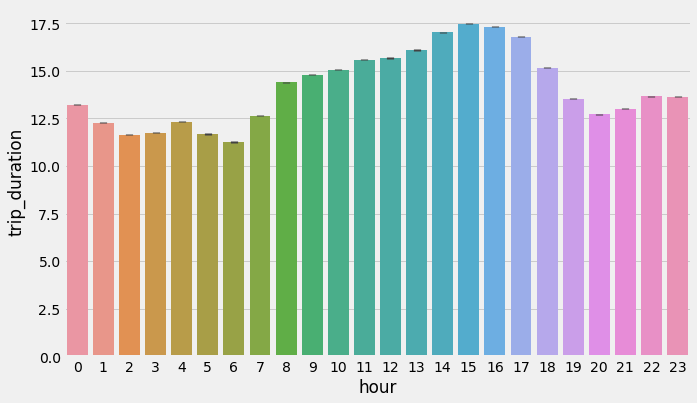

In [121]:
sns.barplot(x='hour', y='trip_duration', data=df)

## Saving a clean copy of dataset

In [281]:
df.to_csv('./data/yellow_tripdata_2015-06_clean.csv')

## Sampling dataset and analyzing Manhattan in detail

In [122]:
def pick_manhattan(row):
    pp = Point(row['pickup_longitude'], row['pickup_latitude'])
    pp = pp.within(manh_poly)
    if pp: return 1 
    else: return 0

In [123]:
def drop_manhattan(row):
    pd = Point(row['dropoff_longitude'], row['dropoff_latitude'])
    pd = pd.within(manh_poly)
    if pd: return 1 
    else: return 0

In [124]:
test = df.sample(100_000)

In [125]:
test['pick_manh'] = test.apply(pick_manhattan, axis=1)
test['drop_manh'] = test.apply(drop_manhattan, axis=1)

In [126]:
test['in_man'] = (test.pick_manh & test.drop_manh)

In [127]:
test['out_man'] = 1 - (test.pick_manh | test.drop_manh)

In [128]:
test.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,improvement_surcharge,total_amount,day,weekday,hour,trip_duration,pick_manh,drop_manh,in_man,out_man
8482787,1,2015-06-21 19:31:45,2015-06-21 19:40:47,1,1.80,-73.983955,40.743713,1,N,-74.002655,...,0.3,11.75,21,6,19,9.033333,1,1,1,0
4088898,2,2015-06-10 22:35:29,2015-06-10 22:41:15,6,0.59,-73.994080,40.722729,1,N,-73.986801,...,0.3,8.16,10,2,22,5.766667,1,0,0,0
4194486,1,2015-06-11 08:13:23,2015-06-11 08:18:48,1,0.80,-73.995064,40.727249,1,N,-73.982910,...,0.3,7.55,11,3,8,5.416667,1,0,0,0
1556519,2,2015-06-04 20:27:20,2015-06-04 20:44:31,3,2.00,-73.981361,40.773720,1,N,-73.964554,...,0.3,16.56,4,3,20,17.183333,1,0,0,0
1934477,1,2015-06-05 17:49:25,2015-06-05 18:01:11,2,2.70,-74.014221,40.713299,1,N,-74.006989,...,0.3,14.55,5,4,17,11.766667,1,1,1,0
6327188,1,2015-06-16 14:29:27,2015-06-16 14:33:09,1,0.10,-73.969528,40.757732,1,Y,-73.973351,...,0.3,5.80,16,1,14,3.700000,0,1,0,0
61980,2,2015-06-01 08:06:11,2015-06-01 08:15:43,1,1.50,-73.983063,40.776524,1,N,-73.974144,...,0.3,9.80,1,0,8,9.533333,1,1,1,0
11048219,2,2015-06-28 03:40:06,2015-06-28 03:47:30,1,2.41,-73.977837,40.745911,1,N,-73.952370,...,0.3,12.36,28,6,3,7.400000,1,0,0,0
10243517,1,2015-06-26 09:31:43,2015-06-26 09:48:39,1,1.00,-73.967484,40.771919,1,N,-73.976929,...,0.3,12.50,26,4,9,16.933333,1,1,1,0
7147523,2,2015-06-18 14:16:29,2015-06-18 14:39:22,1,2.58,-73.982040,40.745972,1,N,-73.959114,...,0.3,20.16,18,3,14,22.883333,1,0,0,0


In [129]:
data = test[(test.pick_manh == 1) & (test.drop_manh == 1)]

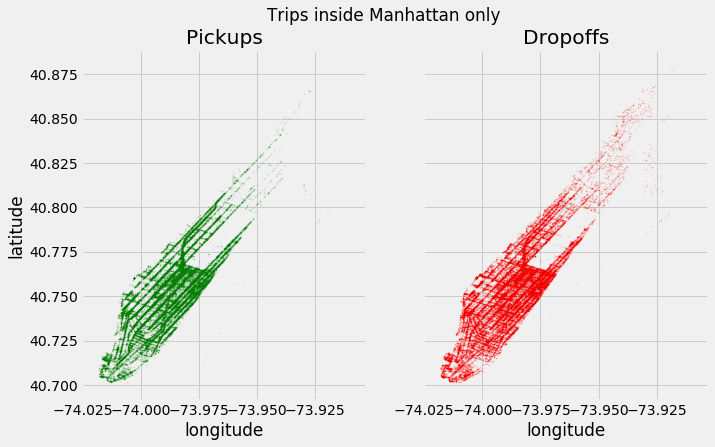

In [130]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
ax = axs[0]
ax.scatter(x=data['pickup_longitude'], y=data['pickup_latitude'], color='green', s=1, alpha=0.1);
ax.set_title('Pickups')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

ax = axs[1]
ax.scatter(x=data['dropoff_longitude'], y=data['dropoff_latitude'], color='red', s=1, alpha=0.1);
ax.set_title('Dropoffs')
ax.set_xlabel('longitude')

fig.suptitle('Trips inside Manhattan only');

In [131]:
excl_in_out = test[(test.in_man == 1) | (test.out_man == 1)]

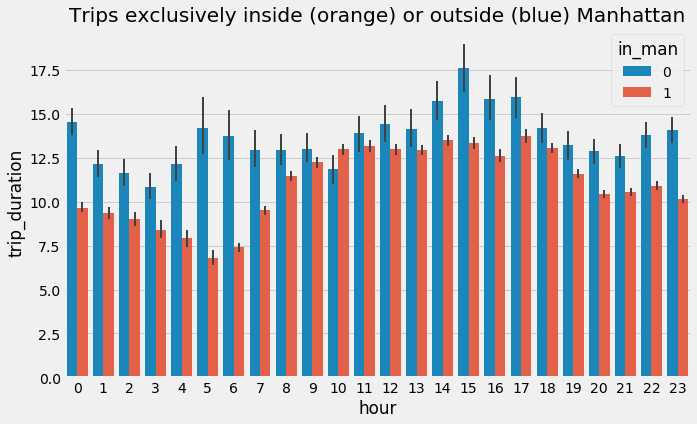

In [133]:
sns.barplot(x='hour', y='trip_duration', data=excl_in_out, errwidth=2,
            hue="in_man").set_title("Trips exclusively inside (orange) or outside (blue) Manhattan");

` locking for trips exclusively inside (orange) or outside (blue) Manhattan, we can see that on pick ours morning and mid afternoon, time is longer. Those times are coincident with airport trips.`

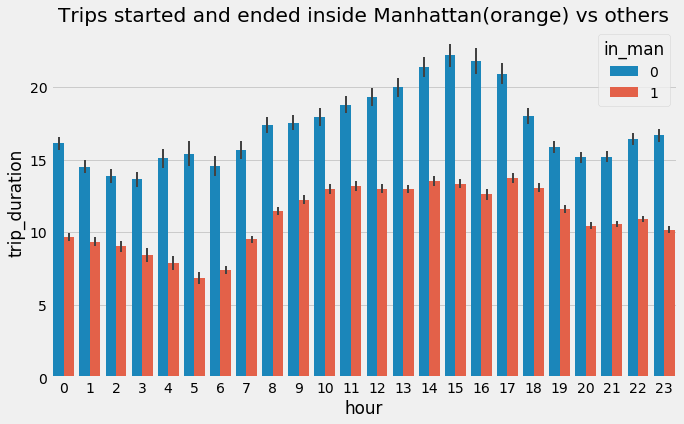

In [135]:
sns.barplot(x='hour', y='trip_duration', data=test, errwidth=2, hue="in_man").set_title(
    "Trips started and ended inside Manhattan(orange) vs others");

`Here trips that are not exclusive in Manhattan (blue) are longer`

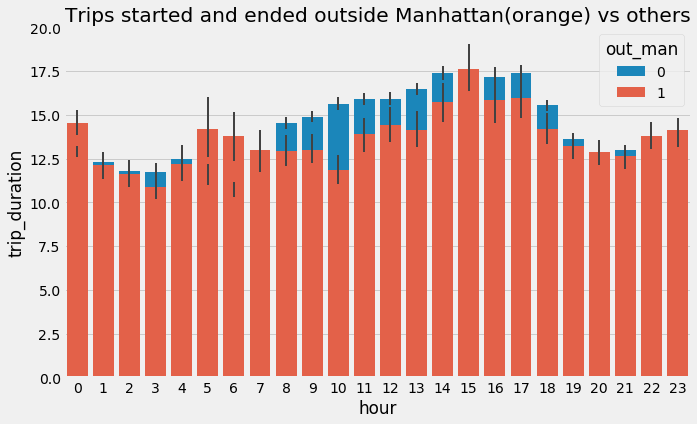

In [136]:
sns.barplot(
    x='hour', y='trip_duration', data=test, errwidth=2, hue="out_man",
    dodge=False).set_title(
        "Trips started and ended outside Manhattan(orange) vs others");

`We can see that during the day, trips outside Manhattan are shorter`

## EDA Conclusion

- Taxi Fare is directly related with distance
- Taxi fare has a completely no linear relation with travel duration
- Hours can play an important role, for example on rush hour, where trips can be longer and fare goes high, night trips, morning and mid afternoon (airport trips), etc.
- Instead of duration of trip, we could also use average speed (miles/h)

---

# Machine Learning

`As discussed on (2), fare and trip duration estimation can be affected for several factors, been the more obvious what the authors call the "basic features" a) start location, b) end location and c) start time of the trip. Spite the fact that that our dataset has real distance, for example, would be difficult have it on prediction, once the real distance will be given by the rout elected by driver. So, we should calculate a reference distance feature and for that, a Haversine distance formula will be used.`

In [23]:
def haver_dist_in_miles(lat1, lat2, long1, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    long1, lat1, long2, lat2 = map(radians, [long1, lat1, long2, lat2])

    # haversine formula
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlong/2)**2
    c = 2 * asin(sqrt(a))
    r = 3956
    return c * r

In [142]:
def calc_haver_dist(row):
    return haver_dist_in_miles(row['pickup_latitude'], row['dropoff_latitude'],
                               row['pickup_longitude'],
                               row['dropoff_longitude'])

In [143]:
test['haver_dist'] = test.apply(calc_haver_dist, axis=1)
test.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,total_amount,day,weekday,hour,trip_duration,pick_manh,drop_manh,in_man,out_man,haver_dist
8482787,1,2015-06-21 19:31:45,2015-06-21 19:40:47,1,1.80,-73.983955,40.743713,1,N,-74.002655,...,11.75,21,6,19,9.033333,1,1,1,0,1.698618
4088898,2,2015-06-10 22:35:29,2015-06-10 22:41:15,6,0.59,-73.994080,40.722729,1,N,-73.986801,...,8.16,10,2,22,5.766667,1,0,0,0,0.417351


In [144]:
test.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'day', 'weekday', 'hour',
       'trip_duration', 'pick_manh', 'drop_manh', 'in_man', 'out_man',
       'haver_dist'],
      dtype='object')

## Preparing Data for ML (Fare Estimation):

In [177]:
dt = test[[
    'passenger_count', 'pickup_longitude', 'pickup_latitude',
    'RateCodeID', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount',
    'weekday', 'hour', 'pick_manh', 'drop_manh', 'in_man',
    'out_man','haver_dist'
]]

In [178]:
dt.head(2)

,passenger_count,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,fare_amount,weekday,hour,pick_manh,drop_manh,in_man,out_man,haver_dist
8482787,1,-73.983955,40.743713,1,-74.002655,40.723602,9.0,6,19,1,1,1,0,1.698618
4088898,6,-73.994080,40.722729,1,-73.986801,40.725201,5.5,2,22,1,0,0,0,0.417351


In [179]:
dt.fare_amount.describe()

count    100000.000000
mean         13.019798
std          10.277032
min           2.500000
25%           6.500000
50%           9.500000
75%          15.000000
max          96.500000
Name: fare_amount, dtype: float64

### Get "baseline"

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [181]:
X = dt.copy()
y = X.pop('fare_amount').values

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [183]:
avg_fare=round(np.mean(y_train),2)
avg_fare

13.03

In [184]:
baseline_pred=np.repeat(avg_fare, y_test.shape[0])
baseline_pred

array([13.03, 13.03, 13.03, ..., 13.03, 13.03, 13.03])

In [185]:
print("RMSE = ${}".format(round(np.sqrt(mean_squared_error(baseline_pred, y_test)), 2)))

RMSE = $10.25


`Our model should produce an error better than $10`  

### Test with Decision Tree Regressor

In [186]:
from sklearn.tree import DecisionTreeRegressor

In [187]:
X = dt.copy()
y = X.pop('fare_amount').values

title = 'Decision_Tree_Regressor'
SPLIT = 0.3
fare_model = DecisionTreeRegressor(max_depth=11, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

dec_tree = fare_model.fit(X_train, y_train)
y_pred = fare_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = ${}".format(RMSE))

RMSE = $3.25


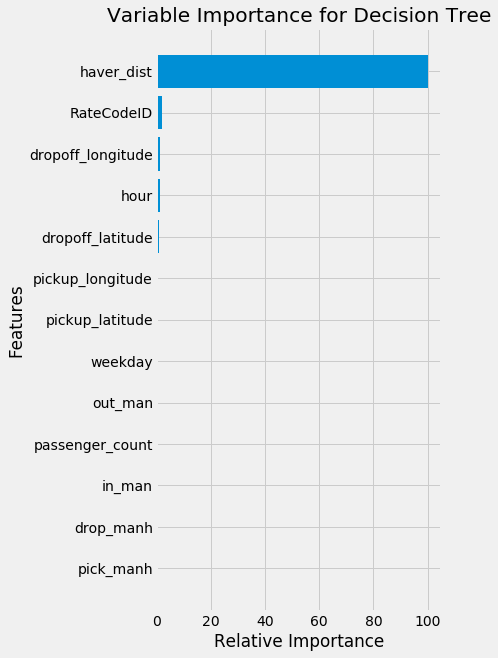

In [188]:
feature_importance = dec_tree.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Decision Tree');

### Test with Random Forest Regressor

In [150]:
from sklearn.ensemble import RandomForestRegressor

In [650]:
X = dt.copy()
y = X.pop('fare_amount').values

title = 'Random Forest Regressor'
SPLIT = 0.3
fare_model = RandomForestRegressor(n_jobs=-1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

random_forest = fare_model.fit(X_train, y_train)
y_pred = fare_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = ${}".format(RMSE))

RMSE = $3.01


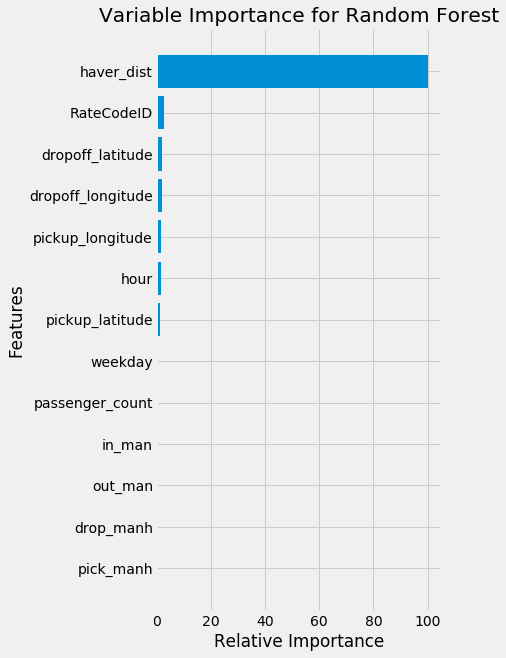

In [651]:
feature_importance = random_forest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest');

### Test with Random Forest Regressor, reducing features

`starting over....` 

In [189]:
dt = test[[
    'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RateCodeID',
    'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'weekday', 'hour',
    'in_man', 'out_man', 'haver_dist'
]]

In [190]:
X = dt.copy()
y = X.pop('fare_amount').values

title = 'Random Forest Regressor_2'
SPLIT = 0.3
fare_model = RandomForestRegressor(n_jobs=-1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

random_forest = fare_model.fit(X_train, y_train)
y_pred = fare_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = ${}".format(RMSE))

RMSE = $3.0


` The RMSE is similar, but the time to run the model was reduced`   

### Test with Random Forest Regressor - changing Hyperparameters

In [151]:
from sklearn.model_selection import RandomizedSearchCV

In [531]:
n_estimators = [int(x) for x in np.linspace(start = 32, stop = 128, num = 4)]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 10, 50]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [32, 64, 96, 128],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 10, 50],
 'bootstrap': [True, False]}

In [532]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 43.5min finished


{'n_estimators': 128,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'bootstrap': False}

In [191]:
X = dt.copy()
y = X.pop('fare_amount').values

title = 'Random_Forest_Regressor_3'
SPLIT = 0.3
fare_model = RandomForestRegressor(
    n_estimators=128,
    max_features='sqrt',
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap = False,
    n_jobs=-1,
    random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

random_forest = fare_model.fit(X_train, y_train)
y_pred = fare_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = ${}".format(RMSE))

RMSE = $2.77


## Preparing Data for ML ( Trip Duration estimation)

In [192]:
dt = test[[
    'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RateCodeID',
    'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'weekday',
    'hour', 'in_man', 'out_man', 'haver_dist'
]]

In [193]:
dt.head(2)

,passenger_count,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,trip_duration,weekday,hour,in_man,out_man,haver_dist
8482787,1,-73.983955,40.743713,1,-74.002655,40.723602,9.033333,6,19,1,0,1.698618
4088898,6,-73.994080,40.722729,1,-73.986801,40.725201,5.766667,2,22,0,0,0.417351


In [194]:
dt.trip_duration.describe()

count    100000.000000
mean         14.513483
std          11.493527
min           0.000000
25%           6.850000
50%          11.416667
75%          18.533333
max         155.183333
Name: trip_duration, dtype: float64

### Get "baseline"

In [195]:
X = dt.copy()
y = X.pop('trip_duration').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

avg_duration = round(np.mean(y_train),2)
avg_duration

14.52

In [196]:
baseline_pred=np.repeat(avg_duration, y_test.shape[0])
print("RMSE = {} min".format(round(np.sqrt(mean_squared_error(baseline_pred, y_test)), 2)))

RMSE = 11.47 min


### Test with Decision Tree Regressor

In [197]:
X = dt.copy()
y = X.pop('trip_duration').values

title = 'Decision_Tree_Regressor_trip_duration'
SPLIT = 0.3
dur_model = DecisionTreeRegressor(max_depth=11, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

dec_tree = dur_model.fit(X_train, y_train)
y_pred = dur_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = {} min".format(RMSE))

RMSE = 6.03 min


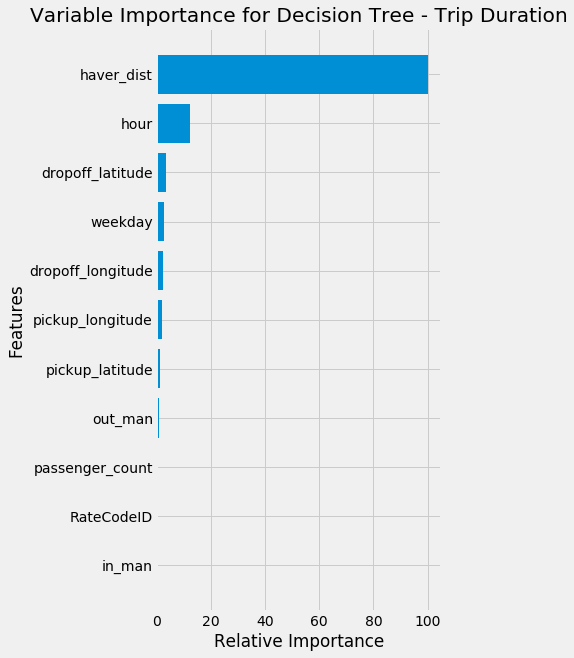

In [198]:
feature_importance = dec_tree.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Decision Tree - Trip Duration');

### Test with Random Forest Regressor

In [199]:
X = dt.copy()
y = X.pop('trip_duration').values

title = 'Random Forest Regressor trip duration'
SPLIT = 0.3
dur_model = RandomForestRegressor(n_jobs=-1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

random_forest = dur_model.fit(X_train, y_train)
y_pred = dur_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = {} min".format(RMSE))

RMSE = 5.6 min


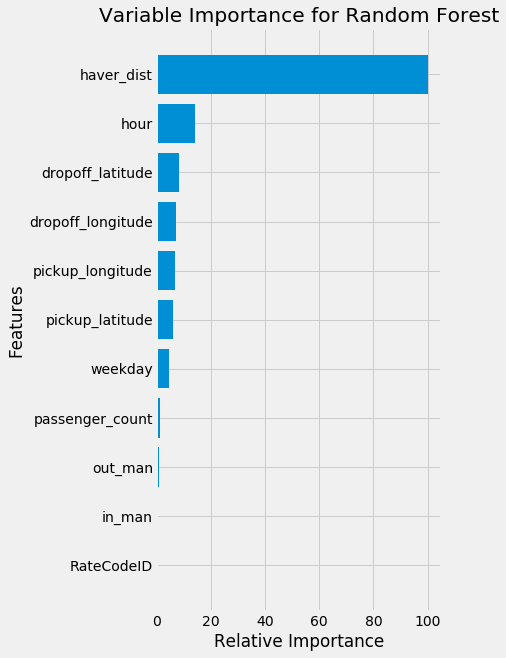

In [200]:
feature_importance = random_forest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest');

In [201]:
X = dt.copy()
y = X.pop('trip_duration').values

title = 'Random_Forest_Regressor_trip_duration'
SPLIT = 0.3
dur_model = RandomForestRegressor(
    n_estimators=128,
    max_features='sqrt',
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap = False,
    n_jobs=-1,
    random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

random_forest = dur_model.fit(X_train, y_train)
y_pred = dur_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = {} min".format(RMSE))

RMSE = 5.26 min


## Preparing Data for ML ( Trip Distance estimation)

In [145]:
dt = test[[
    'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RateCodeID',
    'dropoff_longitude', 'dropoff_latitude', 'trip_distance', 'weekday',
    'hour', 'in_man', 'out_man', 'haver_dist'
]]

dt.head(2)

,passenger_count,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,trip_distance,weekday,hour,in_man,out_man,haver_dist
8482787,1,-73.983955,40.743713,1,-74.002655,40.723602,1.80,6,19,1,0,1.698618
4088898,6,-73.994080,40.722729,1,-73.986801,40.725201,0.59,2,22,0,0,0.417351


In [146]:
dt.trip_distance.describe()

count    100000.000000
mean          3.010972
std           3.611586
min           0.000000
25%           1.030000
50%           1.760000
75%           3.230000
max          38.160000
Name: trip_distance, dtype: float64

### Get "baseline"

In [152]:
X = dt.copy()
y = X.pop('trip_distance').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

avg_distance = round(np.mean(y_train),2)
avg_distance

3.01

In [154]:
baseline_pred = np.repeat(avg_distance, y_test.shape[0])
print("RMSE = {} miles".format(round(np.sqrt(mean_squared_error(baseline_pred, y_test)), 2)))

RMSE = 3.61 miles


### Test with Decision Tree Regressor

In [155]:
X = dt.copy()
y = X.pop('trip_distance').values

title = 'Decision_Tree_Regressor_trip_distance'
SPLIT = 0.3
dis_model = DecisionTreeRegressor(max_depth=11, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

dec_tree = dis_model.fit(X_train, y_train)
y_pred = dis_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = {} miles".format(RMSE))

RMSE = 0.9 miles


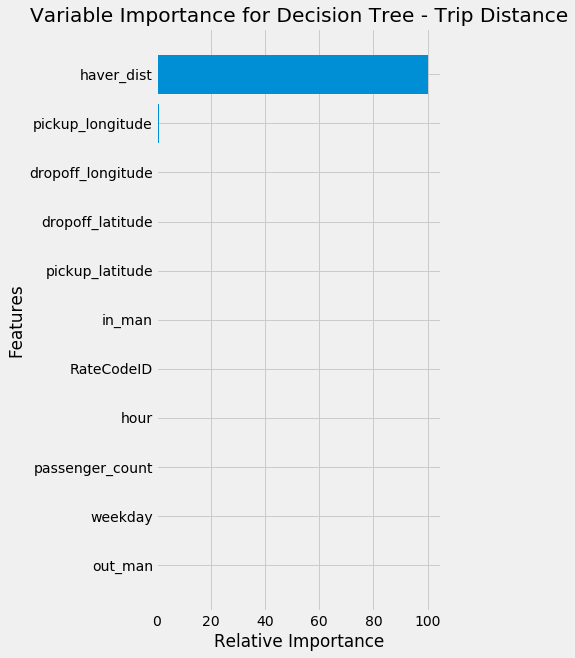

In [156]:
feature_importance = dec_tree.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Decision Tree - Trip Distance');

### Test with Random Forest Regressor

In [157]:
X = dt.copy()
y = X.pop('trip_distance').values

title = 'Random Forest Regressor trip distance'
SPLIT = 0.3
dis_model = RandomForestRegressor(n_jobs=-1, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

random_forest = dis_model.fit(X_train, y_train)
y_pred = dis_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = {} miles".format(RMSE))

RMSE = 0.83 miles


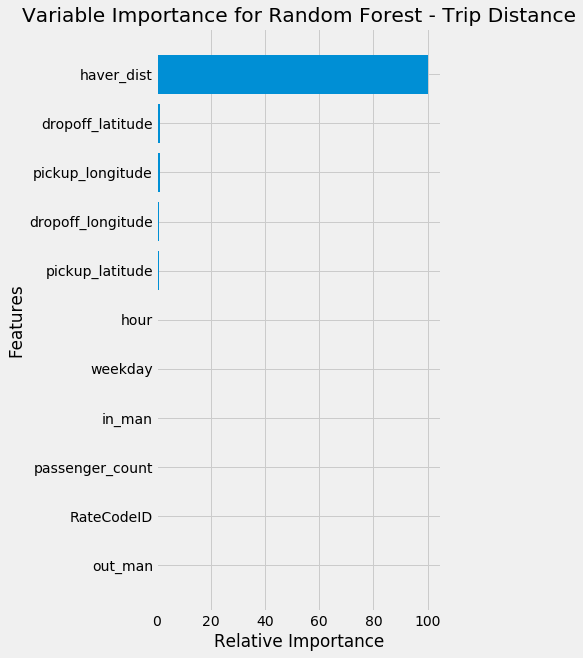

In [158]:
feature_importance = random_forest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest - Trip Distance');

In [159]:
X = dt.copy()
y = X.pop('trip_distance').values

title = 'Random_Forest_Regressor_trip_distance'
SPLIT = 0.3
dis_model = RandomForestRegressor(
    n_estimators=128,
    max_features='sqrt',
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap = False,
    n_jobs=-1,
    random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=123)

random_forest = dis_model.fit(X_train, y_train)
y_pred = dis_model.predict(X_test)

RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 2)
print("RMSE = {} miles".format(RMSE))

RMSE = 0.78 miles


## Testing ML final Algorithm on real data

In [164]:
RateCodeID = 1 
passenger_count = 1 
pickup_longitude = -73.985439
pickup_latitude = 40.748839
dropoff_longitude = -73.998933
dropoff_latitude = 40.707738
in_man = 1
out_man = 0

In [165]:
import datetime as dt
hour = (dt.datetime.now().hour) - 2
weekday = dt.datetime.now().weekday()

In [167]:
haver_dist = haver_dist_in_miles(pickup_latitude, dropoff_latitude,
                                 pickup_longitude, dropoff_longitude)

In [168]:
data_input = pd.DataFrame(
    {
        'passenger_count': passenger_count,
        'pickup_longitude': pickup_longitude,
        'pickup_latitude': pickup_latitude,
        'RateCodeID': RateCodeID,
        'dropoff_longitude': dropoff_longitude,
        'dropoff_latitude': dropoff_latitude,
        'weekday': weekday,
        'hour': hour,
        'in_man': in_man,
        'out_man': out_man,
        'haver_dist': haver_dist
    },
    index=[0],
    columns=[
        'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RateCodeID',
        'dropoff_longitude', 'dropoff_latitude', 'weekday',
        'hour', 'in_man', 'out_man', 'haver_dist'
    ])

In [169]:
data_input

,passenger_count,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,weekday,hour,in_man,out_man,haver_dist
0,1,-73.985439,40.748839,1,-73.998933,40.707738,3,13,1,0,2.924342


In [205]:
fare_pred = fare_model.predict(data_input)
dur_pred = dur_model.predict(data_input)
dis_pred = dis_model.predict(data_input)
print("\nTrip has {} miles and will last {} minutes, with a basic cost od ${}".
      format(
          round(dis_pred[0], 2), round(dur_pred[0], 1), round(fare_pred[0],
                                                              2)))


Trip has 4.48 miles and will last 22.5 minutes, with a basic cost od $18.46


Using https://www.taxifarefinder.com we got the following result:<br>
- Fare: $21.25
- Dist: 5.1 miles
- Time: 14 min

Both fare and trip distance results are inside the expected error ($2.8 and 5.3 minutes). Duration is out of error, but checking on Google, time is between 21 and 27 min and a distance from 3.7 to 5.2 miles. Very good result!

`The App is good for Fare, but Google Maps should be better for distance and time.`

###  Criating a function

In [29]:
def estimate_nyc_taxi_fare_duration(pickup_longitude,
                                    pickup_latitude,
                                    dropoff_longitude,
                                    dropoff_latitude,
                                    RateCodeID=1,
                                    passenger_count=1,
                                    in_man=1,
                                    out_man=0):

    import datetime as dt
    hour = (dt.datetime.now().hour) - 2
    weekday = dt.datetime.now().weekday()

    haver_dist = haver_dist_in_miles(pickup_latitude, dropoff_latitude,
                                   pickup_longitude, dropoff_longitude)

    data_input = pd.DataFrame(
        {
            'passenger_count': passenger_count,
            'pickup_longitude': pickup_longitude,
            'pickup_latitude': pickup_latitude,
            'RateCodeID': RateCodeID,
            'dropoff_longitude': dropoff_longitude,
            'dropoff_latitude': dropoff_latitude,
            'weekday': weekday,
            'hour': hour,
            'in_man': in_man,
            'out_man': out_man,
            'haver_dist': haver_dist
        },
        index=[0],
        columns=[
            'passenger_count', 'pickup_longitude', 'pickup_latitude',
            'RateCodeID', 'dropoff_longitude', 'dropoff_latitude', 'weekday',
            'hour', 'in_man', 'out_man', 'haver_dist'
        ])

    fare_pred = fare_model.predict(data_input)
    dur_pred = dur_model.predict(data_input)
    dis_pred = dis_model.predict(data_input)
    print("\nTrip has {} miles and will last {} minutes, with a basic cost od ${}".format(
        round(dis_pred[0], 2), round(dur_pred[0], 1), round(fare_pred[0], 2)))

In [209]:
# Columbia University to Empire State
pickup_longitude = -73.963936
pickup_latitude = 40.808108
dropoff_longitude = -73.984686
dropoff_latitude = 40.748333

estimate_nyc_taxi_fare_duration(pickup_longitude, pickup_latitude,
                                dropoff_longitude, dropoff_latitude)


Trip has 5.51 miles and will last 34.4 minutes, with a basic cost od $24.38


- At app: $23.07
- By Google from 30 to 41 minutes and 5 to 7 miles

In [212]:
# Julliard School to Washington Square
pickup_longitude = -73.983730
pickup_latitude = 40.773682
dropoff_longitude = -73.999591
dropoff_latitude = 40.731828

estimate_nyc_taxi_fare_duration(pickup_longitude, pickup_latitude,
                                dropoff_longitude, dropoff_latitude)


Trip has 3.59 miles and will last 27.8 minutes, with a basic cost od $19.73


- At app: $16.52
- By Google from 23 to 31 minutes and 3.4 to 3.6 miles

In [213]:
# Columbia University to JFK
pickup_longitude = -73.963936
pickup_latitude = 40.808108
dropoff_longitude = -73.788391
dropoff_latitude = 40.647176

estimate_nyc_taxi_fare_duration(
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude,
    RateCodeID=2,
    passenger_count=1,
    in_man=0,
    out_man=1)


Trip has 18.66 miles and will last 50.4 minutes, with a basic cost od $52.0


- By Google, time: between 52 and 59 minutes and 16.6 to 21.2 miles
- By App JFK Flat Fare: $52

### Using Geo locator 

In [32]:
start_point = "LGA"
ending_point = "Empire State Building"

geolocator = Nominatim(user_agent="mjrovai")
start_point = geolocator.geocode(start_point)
ending_point = geolocator.geocode(ending_point)

estimate_nyc_taxi_fare_duration(
    start_point.longitude,
    start_point.latitude,
    ending_point.longitude,
    ending_point.latitude,
    RateCodeID=1,
    passenger_count=1,
    in_man=0,
    out_man=0)


Trip has 9.24 miles and will last 33.2 minutes, with a basic cost od $31.25


In [33]:
start_point = "Columbia University"
ending_point = "Empire State Building"

geolocator = Nominatim(user_agent="mjrovai")
start_point = geolocator.geocode(start_point)
ending_point = geolocator.geocode(ending_point)

estimate_nyc_taxi_fare_duration(
    start_point.longitude,
    start_point.latitude,
    ending_point.longitude,
    ending_point.latitude,
    RateCodeID=1,
    passenger_count=1,
    in_man=1,
    out_man=0)


Trip has 8.3 miles and will last 27.2 minutes, with a basic cost od $24.45


In [34]:
start_point = "times square"
ending_point = "JFK"

geolocator = Nominatim(user_agent="mjrovai")
start_point = geolocator.geocode(start_point)
ending_point = geolocator.geocode(ending_point)

estimate_nyc_taxi_fare_duration(
    start_point.longitude,
    start_point.latitude,
    ending_point.longitude,
    ending_point.latitude,
    RateCodeID=2,
    passenger_count=1,
    in_man=0,
    out_man=0)


Trip has 18.13 miles and will last 50.4 minutes, with a basic cost od $52.0


In [35]:
start_point = "Carnegie Hall"
ending_point = "EWR"

geolocator = Nominatim(user_agent="mjrovai")
start_point = geolocator.geocode(start_point)
ending_point = geolocator.geocode(ending_point)

estimate_nyc_taxi_fare_duration(
    start_point.longitude,
    start_point.latitude,
    ending_point.longitude,
    ending_point.latitude,
    RateCodeID=1,
    passenger_count=1,
    in_man=0,
    out_man=0)


Trip has 15.81 miles and will last 41.5 minutes, with a basic cost od $51.15


### Creating a function with Geo Location

In [41]:
def nyc_trip_estimation(start_loc, end_loc, passenger_count=1):

    geolocator = Nominatim(user_agent="mjrovai")
    start_point = geolocator.geocode(start_loc)
    end_point = geolocator.geocode(end_loc)

    sp = Point(start_point.longitude, start_point.latitude)
    sp = sp.within(manh_poly)
    ep = Point(end_point.longitude, end_point.latitude)
    ep = ep.within(manh_poly)

    if (sp == True) and (ep == True):
        in_man = 1
        trip = 'inside Manhattan'
    else:
        in_man = 0

    if (sp == False) and (ep == False):
        out_man = 1
        trip = 'outside Manhattan'
    else:
        out_man = 0

    if (in_man == 0) and (out_man == 0):
        trip = 'partially in Manhattan'
        
    if (sp == True) and (end_loc == 'JFK'):
        RateCodeID = 2
        Code = 'JFK'
    elif end_loc == 'EWR':
        RateCodeID = 3
        Code = 'EWR'
    else:
        RateCodeID = 1
        Code = 'Standard'

    estimate_nyc_taxi_fare_duration(
        start_point.longitude,
        start_point.latitude,
        end_point.longitude,
        end_point.latitude,
        RateCodeID=RateCodeID,
        passenger_count=passenger_count,
        in_man=in_man,
        out_man=out_man)

    print(
        "[Trip Info]: Trip {}; Rate Code: {}"
        .format(trip, Code))
    
    return start_point.latitude, start_point.longitude, end_point.latitude, end_point.longitude,

In [42]:
def plot_map(plat, plon, dlat, dlon):
    pickup = [plat, plon]
    dropoff = [dlat, dlon]

    map_center = ((plat + dlat) / 2), ((plon + dlon) / 2)
    m = Map(center=map_center)

    mp = Marker(location=pickup, draggable=True, opacity = 1, title = 'Pickup')
    m.add_layer(mp);

    md = Marker(location=dropoff, draggable=True, opacity = 0.5, title='Dropoff')
    m.add_layer(md);

    return m, mp, md

In [43]:
def predict_trip(start_loc, end_loc):
    plat, plon, dlat, dlon = nyc_trip_estimation(start_loc, end_loc)
    m, mp, md = plot_map(plat, plon, dlat, dlon)
    return m

In [44]:
start_loc = "Empire State Building"
end_loc = "Brooklyn Bridge"

predict_trip(start_loc, end_loc)


Trip has 5.3 miles and will last 23.8 minutes, with a basic cost od $19.99
[Trip Info]: Trip partially in Manhattan; Rate Code: Standard


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [45]:
start_loc = "Columbia University"
end_loc = "Empire State Building"

predict_trip(start_loc, end_loc)


Trip has 8.4 miles and will last 27.7 minutes, with a basic cost od $24.39
[Trip Info]: Trip inside Manhattan; Rate Code: Standard


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [46]:
start_loc = "Carnegie Hall"
end_loc = "EWR"

predict_trip(start_loc, end_loc)


Trip has 18.69 miles and will last 39.6 minutes, with a basic cost od $68.58
[Trip Info]: Trip partially in Manhattan; Rate Code: EWR


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [47]:
start_loc = "Hoboken NJ"
end_loc = "JFK"

predict_trip(start_loc, end_loc)


Trip has 19.05 miles and will last 63.9 minutes, with a basic cost od $63.07
[Trip Info]: Trip outside Manhattan; Rate Code: Standard


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [48]:
start_loc = "Empire State Building"
end_loc = "JFK"

predict_trip(start_loc, end_loc)


Trip has 17.22 miles and will last 49.9 minutes, with a basic cost od $52.0
[Trip Info]: Trip partially in Manhattan; Rate Code: JFK


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Offline Trip Prediction directly from Map

In [77]:
def get_mark_locations():   
    d = 0.01
    NYC_center = [40.7227, -74.0039]
    pickup = [NYC_center[0]-d, NYC_center[1]-d]
    dropoff = [NYC_center[0]+d, NYC_center[1]+d]
    m = Map(center=NYC_center)

    mp = Marker(location=pickup, draggable=True, opacity = 1, title = 'Pickup')
    m.add_layer(mp);

    md = Marker(location=dropoff, draggable=True, opacity = 0.5, title='Dropoff')
    m.add_layer(md);

    return m, mp, md

In [78]:
m, mp, md = get_mark_locations()
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

**Drag Marks on above map (DO NOT execute the cell) and execute below cel:**

In [80]:
trip_inside_Manhattan = 1
trip_outside_Manhattan = 0
TRIP_TYPE = 1 # 1:Standard; 2:JFK; 3:EWR

estimate_nyc_taxi_fare_duration(mp.location[1],
                                    mp.location[0],
                                    md.location[1],
                                    md.location[0],
                                    RateCodeID=TRIP_TYPE,
                                    passenger_count=1,
                                    in_man=trip_inside_Manhattan,
                                    out_man=trip_outside_Manhattan)


Trip has 2.35 miles and will last 18.5 minutes, with a basic cost od $12.63


## Saving ML models 

In [2]:
import pickle
from sklearn.externals import joblib

In [775]:
# Save the fare model as a pickle in a file
joblib.dump(fare_model, './models/fare_model.pkl') 

['fare_model.pkl']

In [776]:
# Save the duration model as a pickle in a file
joblib.dump(dur_model, './models/dur_model.pkl') 

['dur_model.pkl']

In [161]:
# Save the distance model as a pickle in a file
joblib.dump(dis_model, './models/dis_model.pkl') 

['dis_model.pkl']

## Loading and testing saved ML models

In [25]:
# Load the fare model from a pickled file
fare_model_from_joblib = joblib.load('./models/fare_model.pkl')

In [26]:
# Load the duration model from a pickled file
dur_model_from_joblib = joblib.load('./models/dur_model.pkl')

In [27]:
# Load the distance model from a pickled file
dis_model_from_joblib = joblib.load('./models/dis_model.pkl')

In [220]:
data_input

,passenger_count,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,weekday,hour,in_man,out_man,haver_dist
0,1,-73.985439,40.748839,1,-73.998933,40.707738,3,13,1,0,2.924342


In [221]:
fare_pred = fare_model_from_joblib.predict(data_input)
dur_pred = dur_model_from_joblib.predict(data_input)
dis_pred = dis_model_from_joblib.predict(data_input)
print("\nTrip has {} miles and will last {} minutes, with a basic cost od ${}".
      format(
          round(dis_pred[0], 2), round(dur_pred[0], 1), round(fare_pred[0],
                                                              2)))


Trip has 4.48 miles and will last 22.2 minutes, with a basic cost od $17.57
